# Consensus Clustering

## Purpose
The purpose of this step is to run consensus clustering.

## Input
- HVF adata files.

## Output
- HVF adata file with cluster annotated.

## Import

In [1]:
import pathlib
import anndata
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ALLCools.clustering import ConsensusClustering, Dendrogram
from ALLCools.plot import *

## Parameters

In [2]:
# clustering name
clustering_name = 'L1'

# input data
cell_meta_path = './CellMetadata.PassQC.csv.gz'
adata_path = './adata.with_coords.h5ad'
coord_base = 'tsne'

# ConsensusClustering
n_neighbors = 25
metric = 'euclidean'
min_cluster_size = 10
consensus_rate = 0.5
leiden_repeats = 500
leiden_resolution = 0.8
random_state = 0
n_jobs = 40
train_frac = 0.5
train_max_n = 500
max_iter = 20
outlier_cell_cutoff = 0.25
outlier_label = 'Outlier'

# Dendrogram via Multiscale Bootstrap Resampling
nboot = 10000
method_dist = 'correlation'
method_hclust = 'average'

plot_type = 'static'

## Load Data

In [3]:
cell_meta = pd.read_csv(cell_meta_path, index_col=0)
adata = anndata.read_h5ad(adata_path)

## Consensus Clustering

In [4]:
cc = ConsensusClustering(model=None,
                         n_neighbors=n_neighbors,
                         metric=metric,
                         min_cluster_size=min_cluster_size,
                         consensus_rate=consensus_rate,
                         repeats=leiden_repeats,
                         resolution=leiden_resolution,
                         random_state=random_state,
                         train_frac=train_frac,
                         train_max_n=train_max_n,
                         max_iter=max_iter,
                         n_jobs=n_jobs,
                         outlier_cell_cutoff=outlier_cell_cutoff,
                         outlier_label=outlier_label,
                         plot=True)

Computing nearest neighbor graph
Computing multiple clustering with different random seeds
Repeating leiden clustering 500 times
Found 26 - 27 clusters, mean 27.0, std 0.04
Summarizing multiple clustering results
4825 cells assigned to 43 raw clusters
133 cells are outliers

=== Start supervise model training and cluster merging ===

=== iteration 1 ===
43 non-outlier labels
Balanced accuracy on the training set: 0.966
Balanced accuracy on the hold-out set: 0.911
Distance between 7 - 8: 0.004 < 0.500
Merging 1 clusters.

=== iteration 2 ===
42 non-outlier labels
Balanced accuracy on the training set: 0.965
Balanced accuracy on the hold-out set: 0.914
Distance between 35 - 0: 0.002 < 0.500
Merging 1 clusters.

=== iteration 3 ===
41 non-outlier labels
Balanced accuracy on the training set: 0.966
Balanced accuracy on the hold-out set: 0.897
Distance between 23 - 10: 0.008 < 0.500
Merging 1 clusters.

=== iteration 4 ===
40 non-outlier labels
Balanced accuracy on the training set: 0.970
B

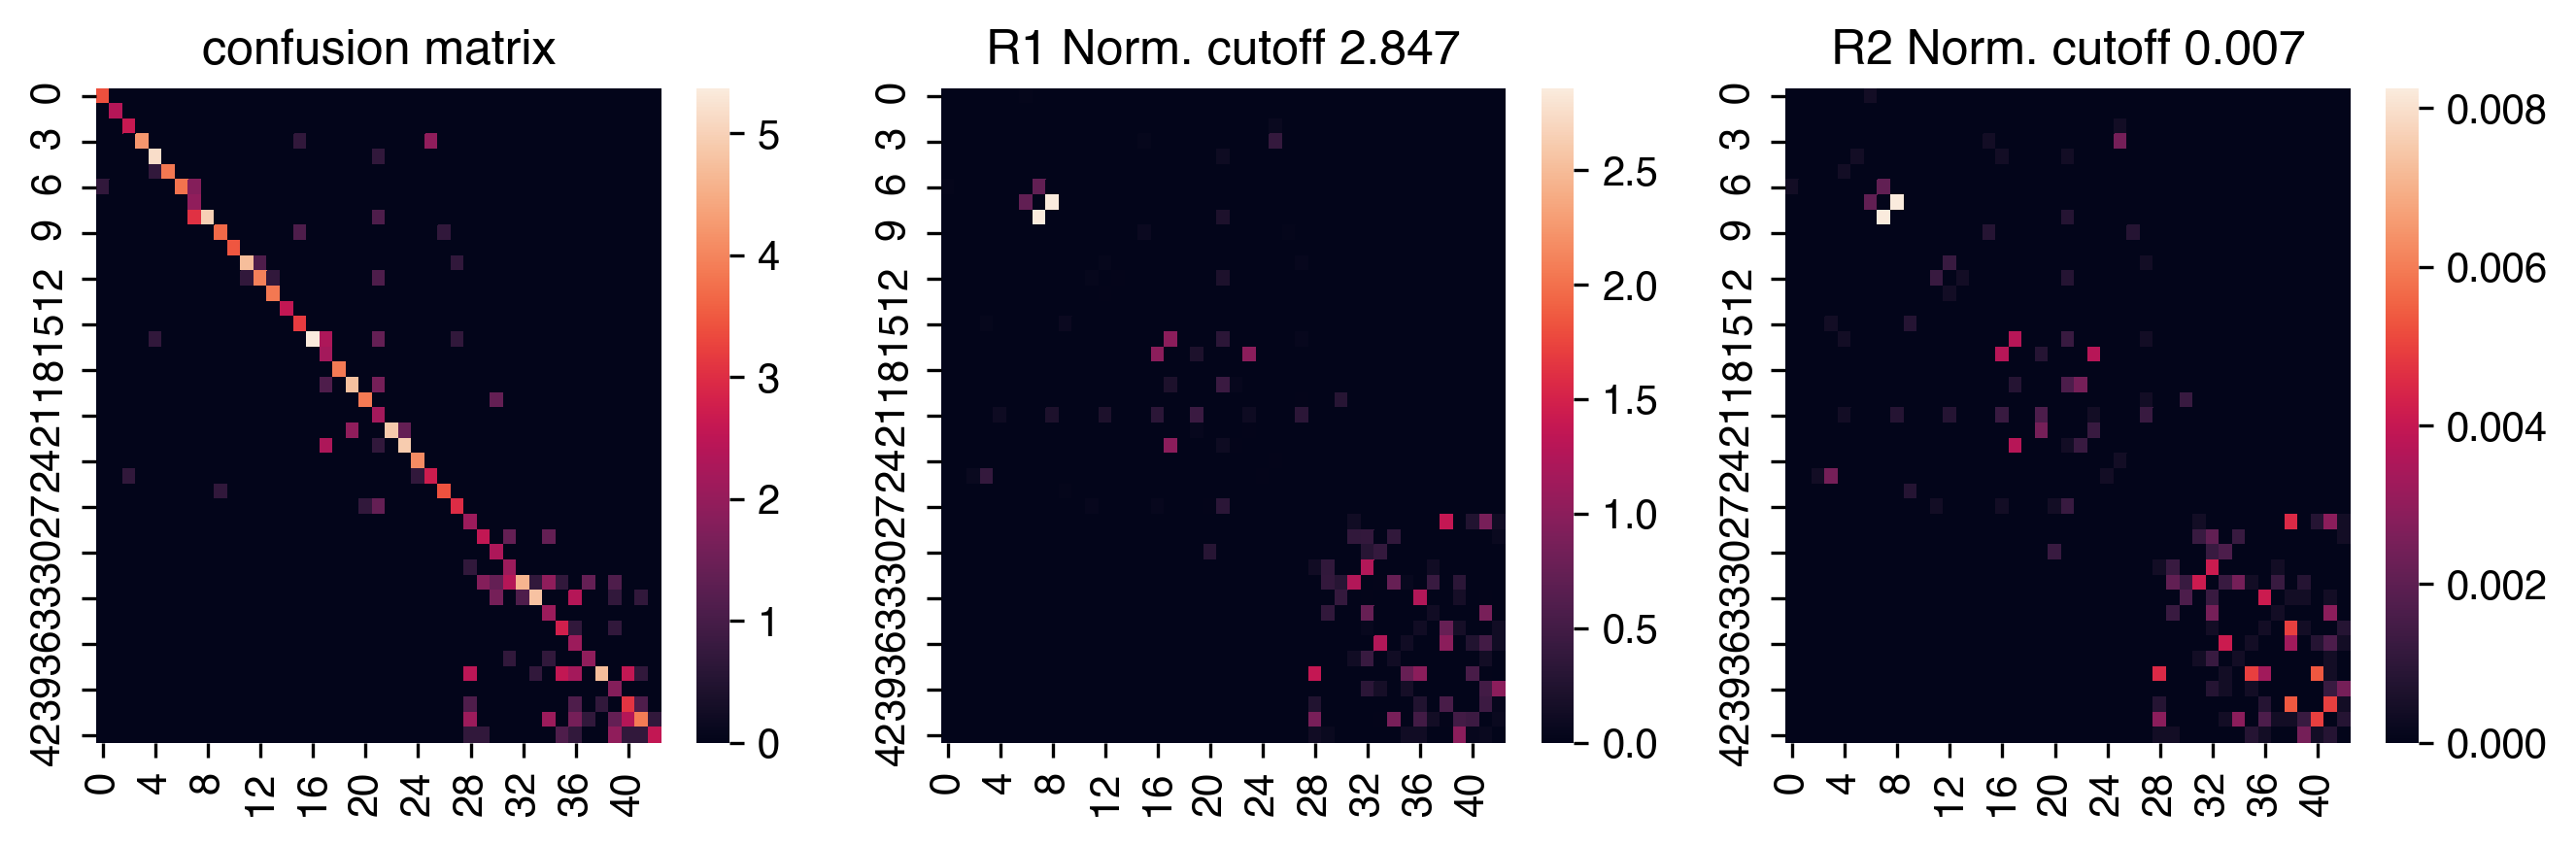

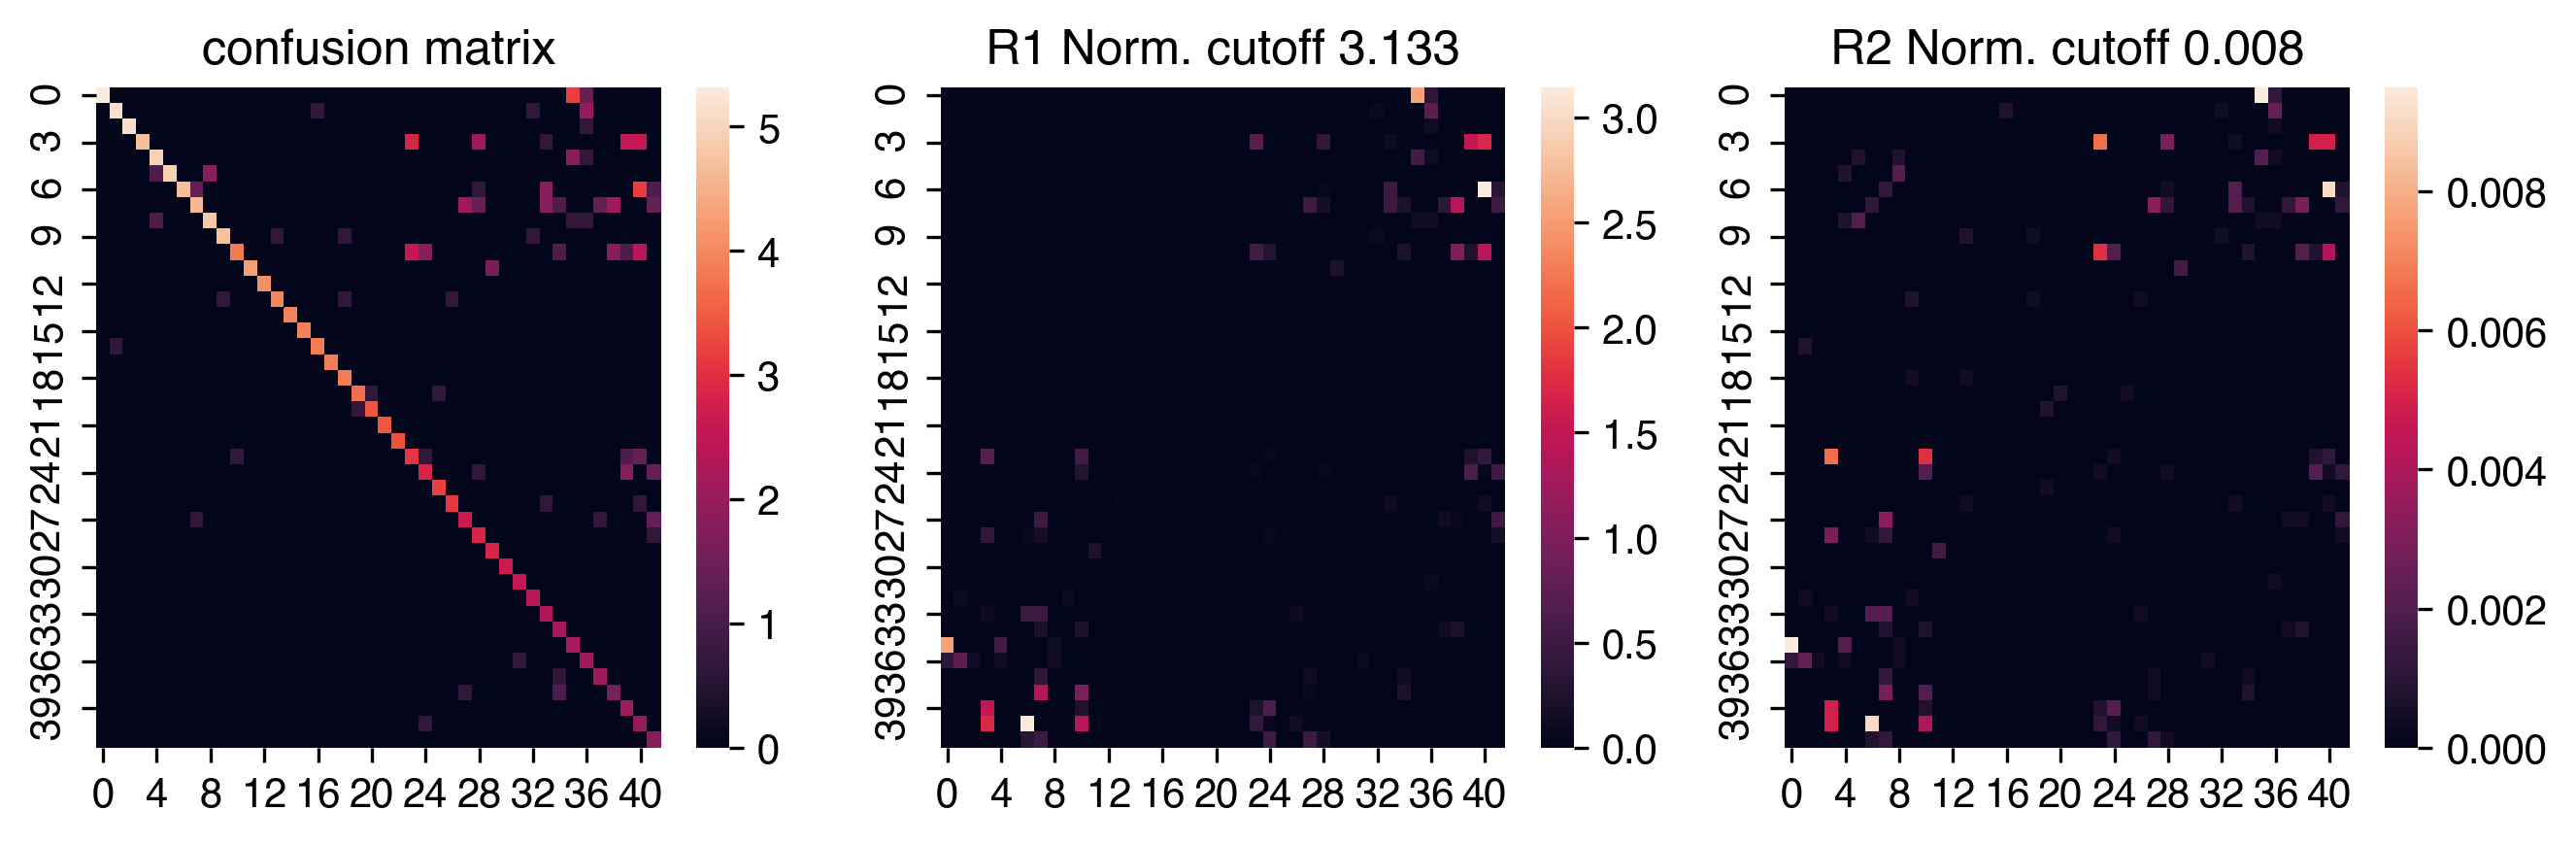

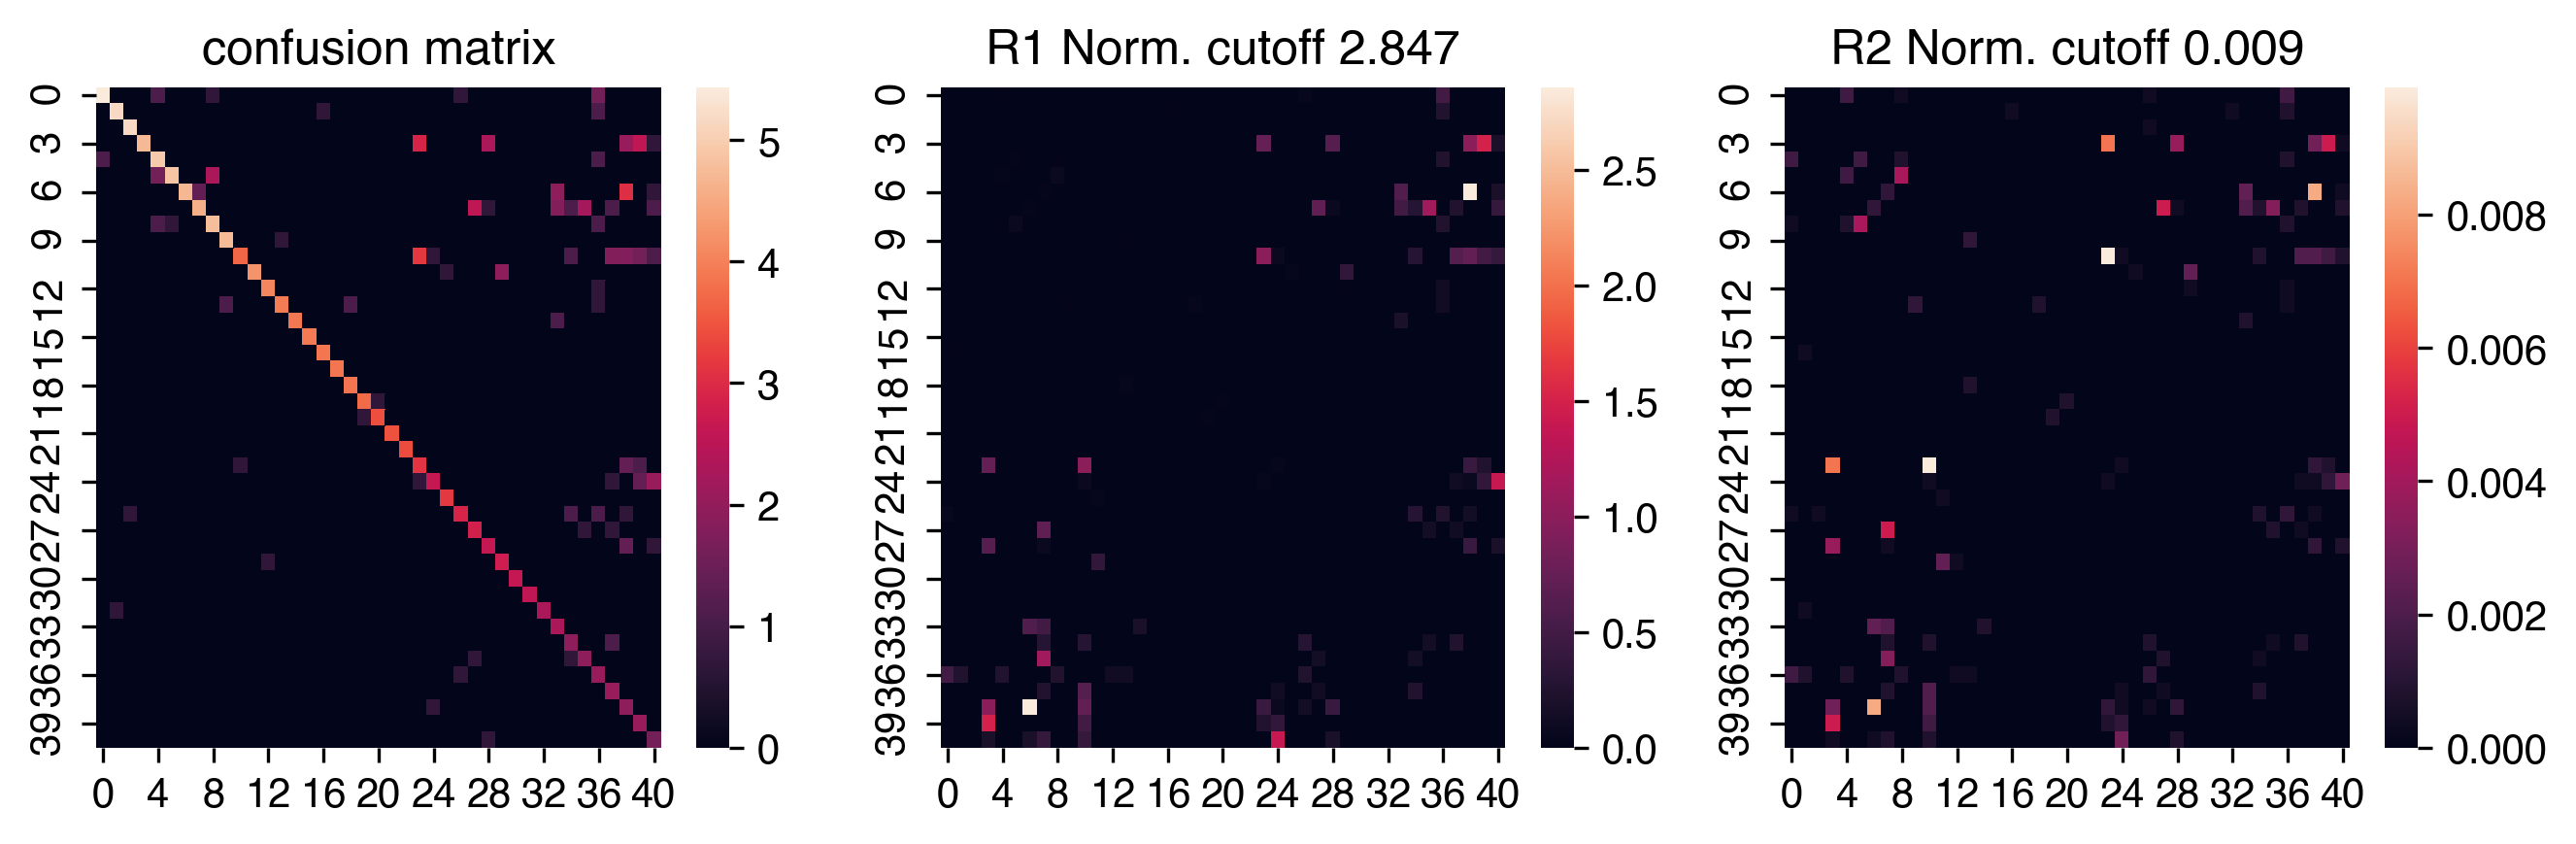

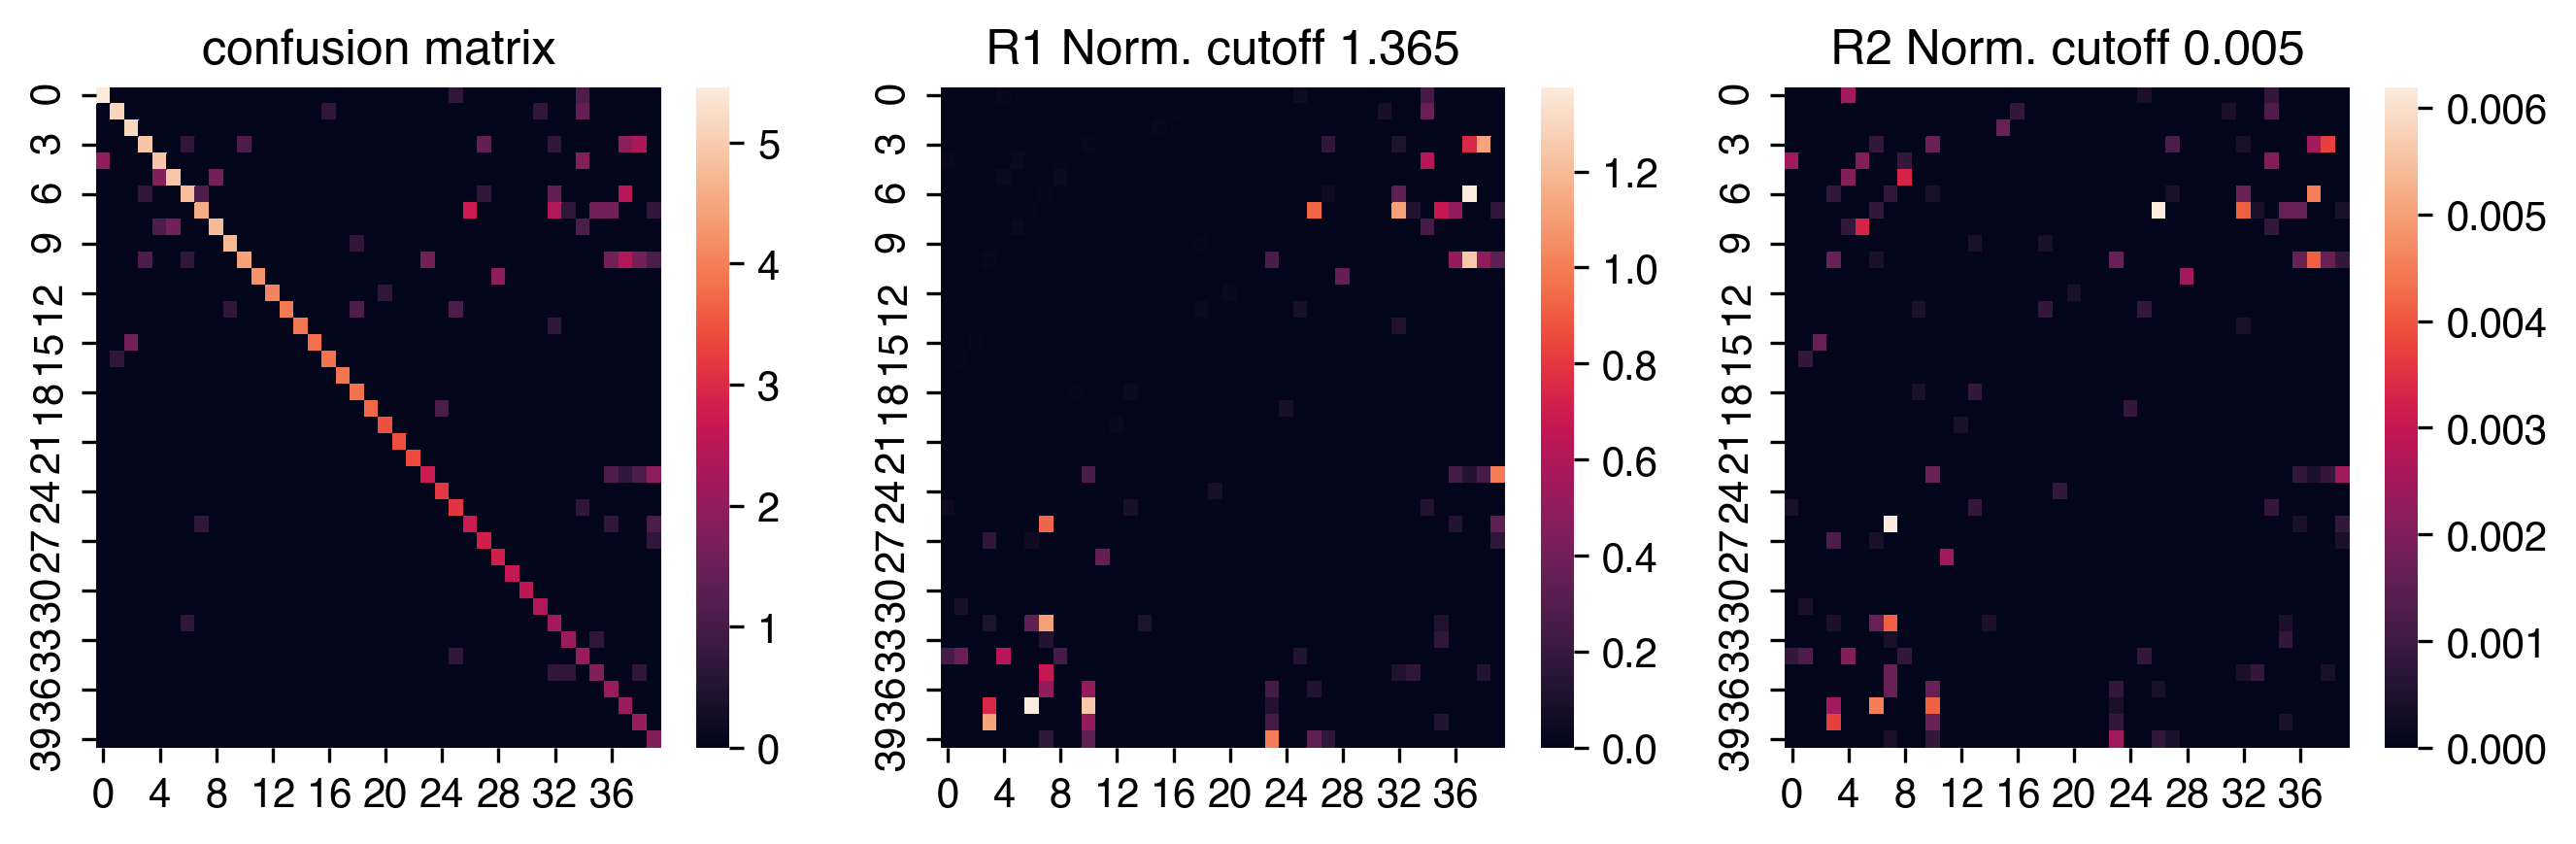

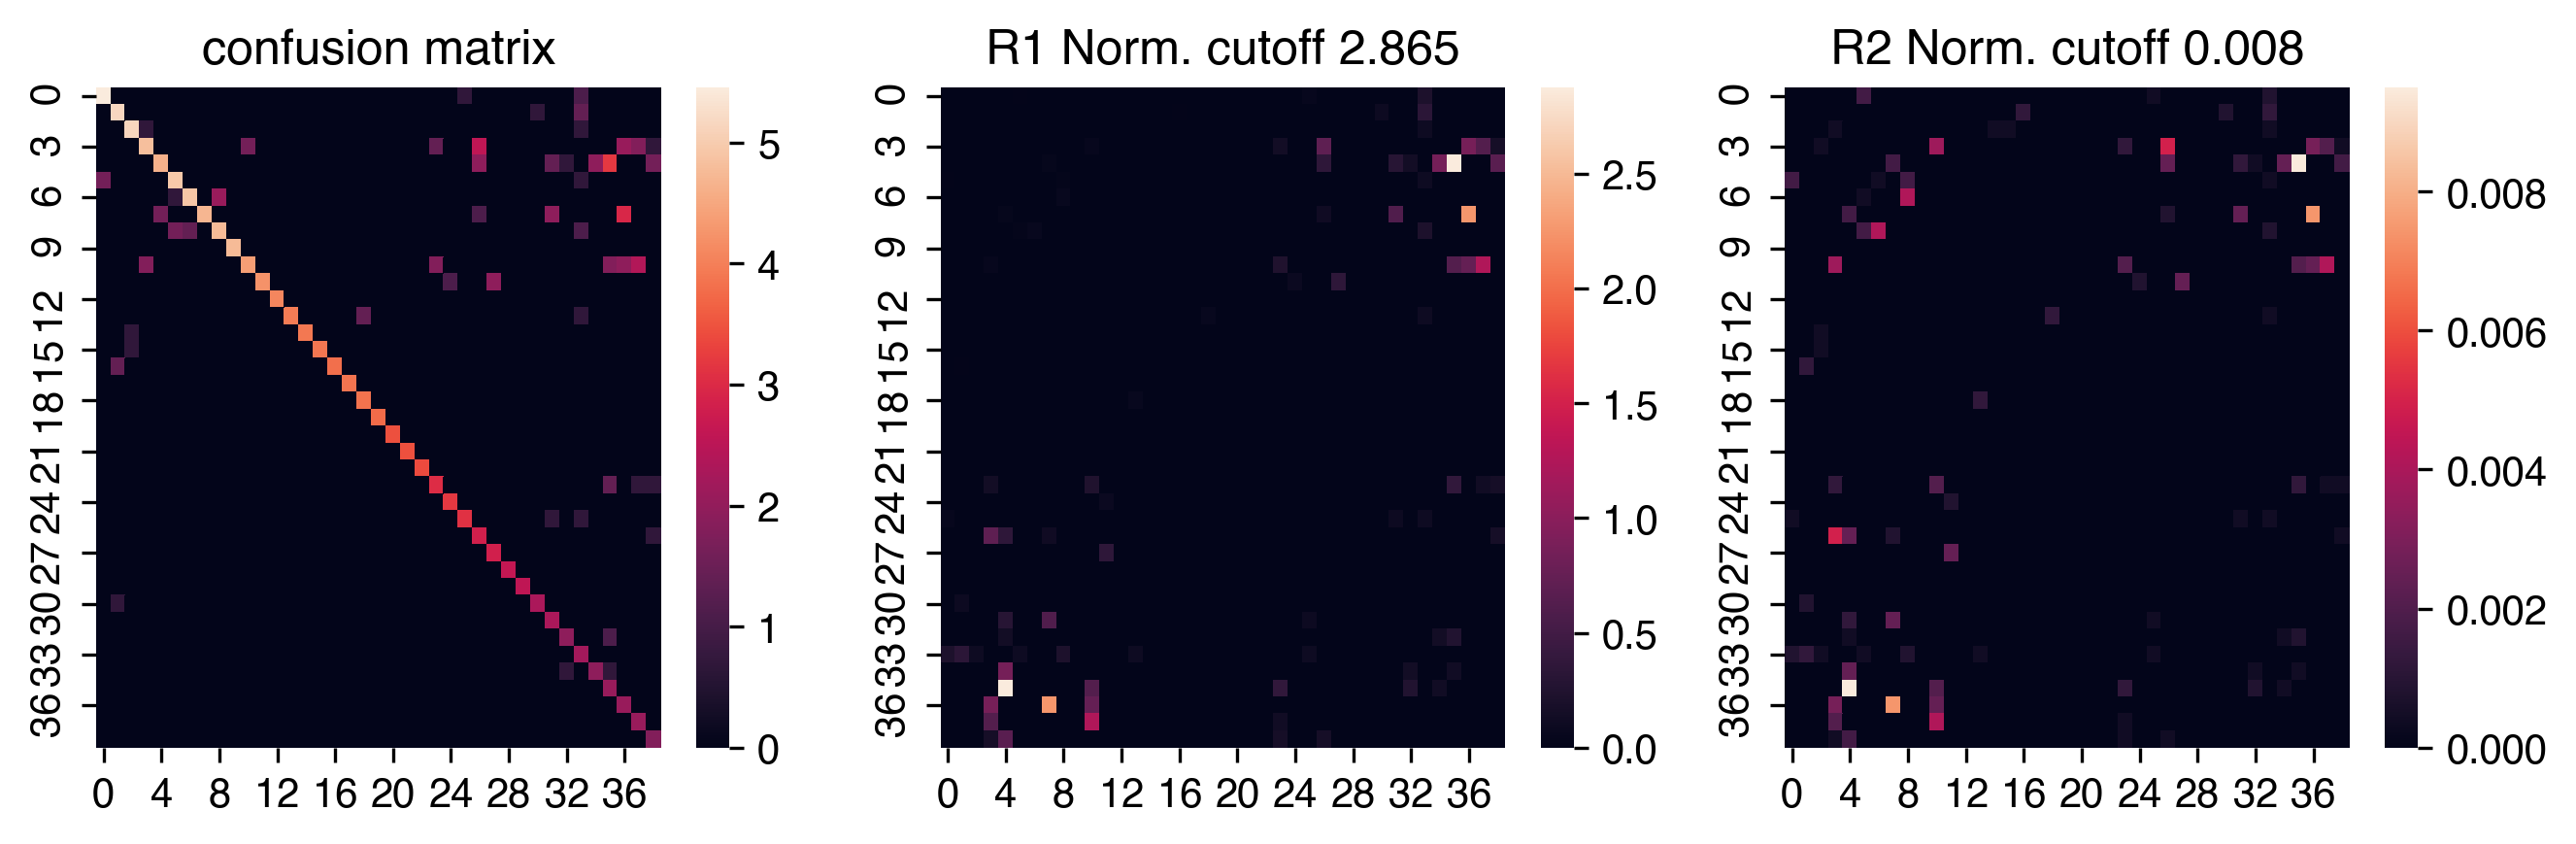

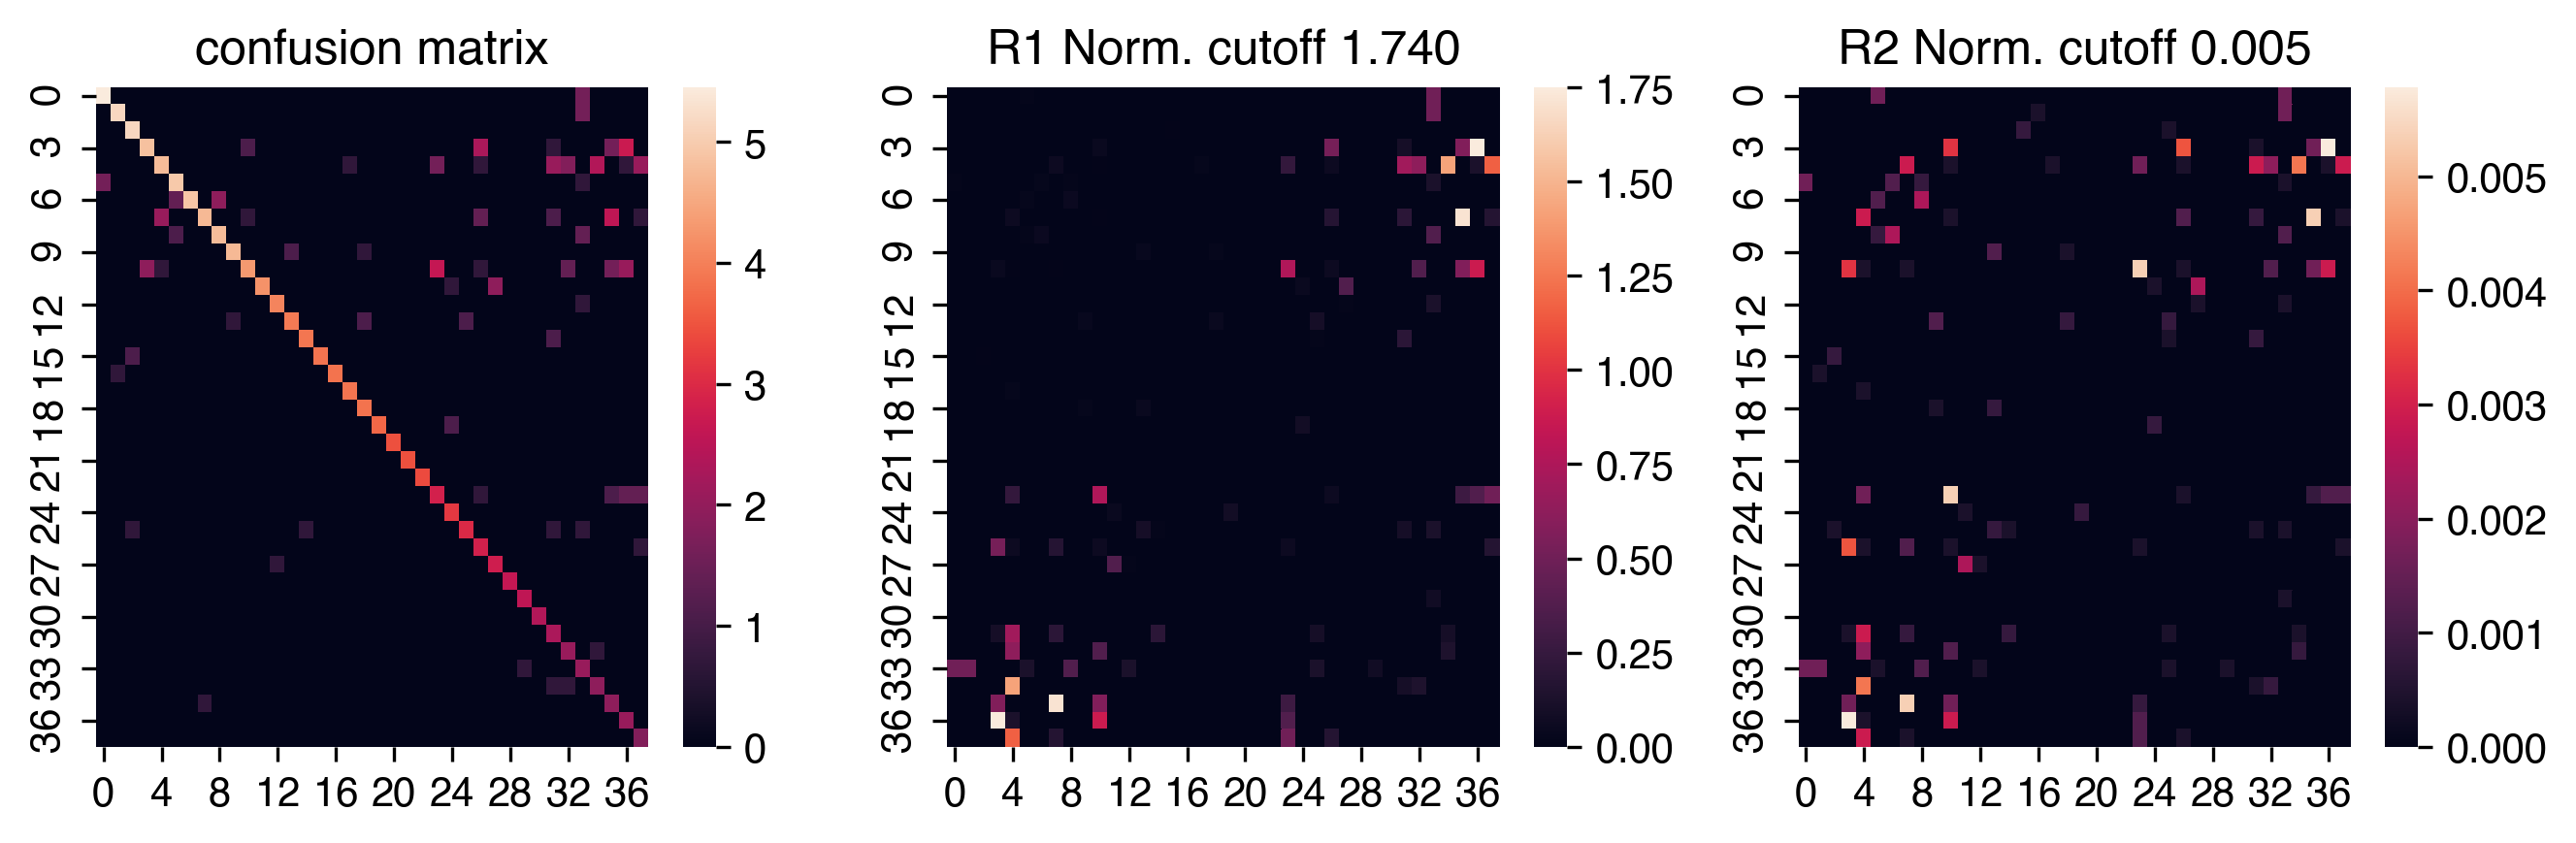

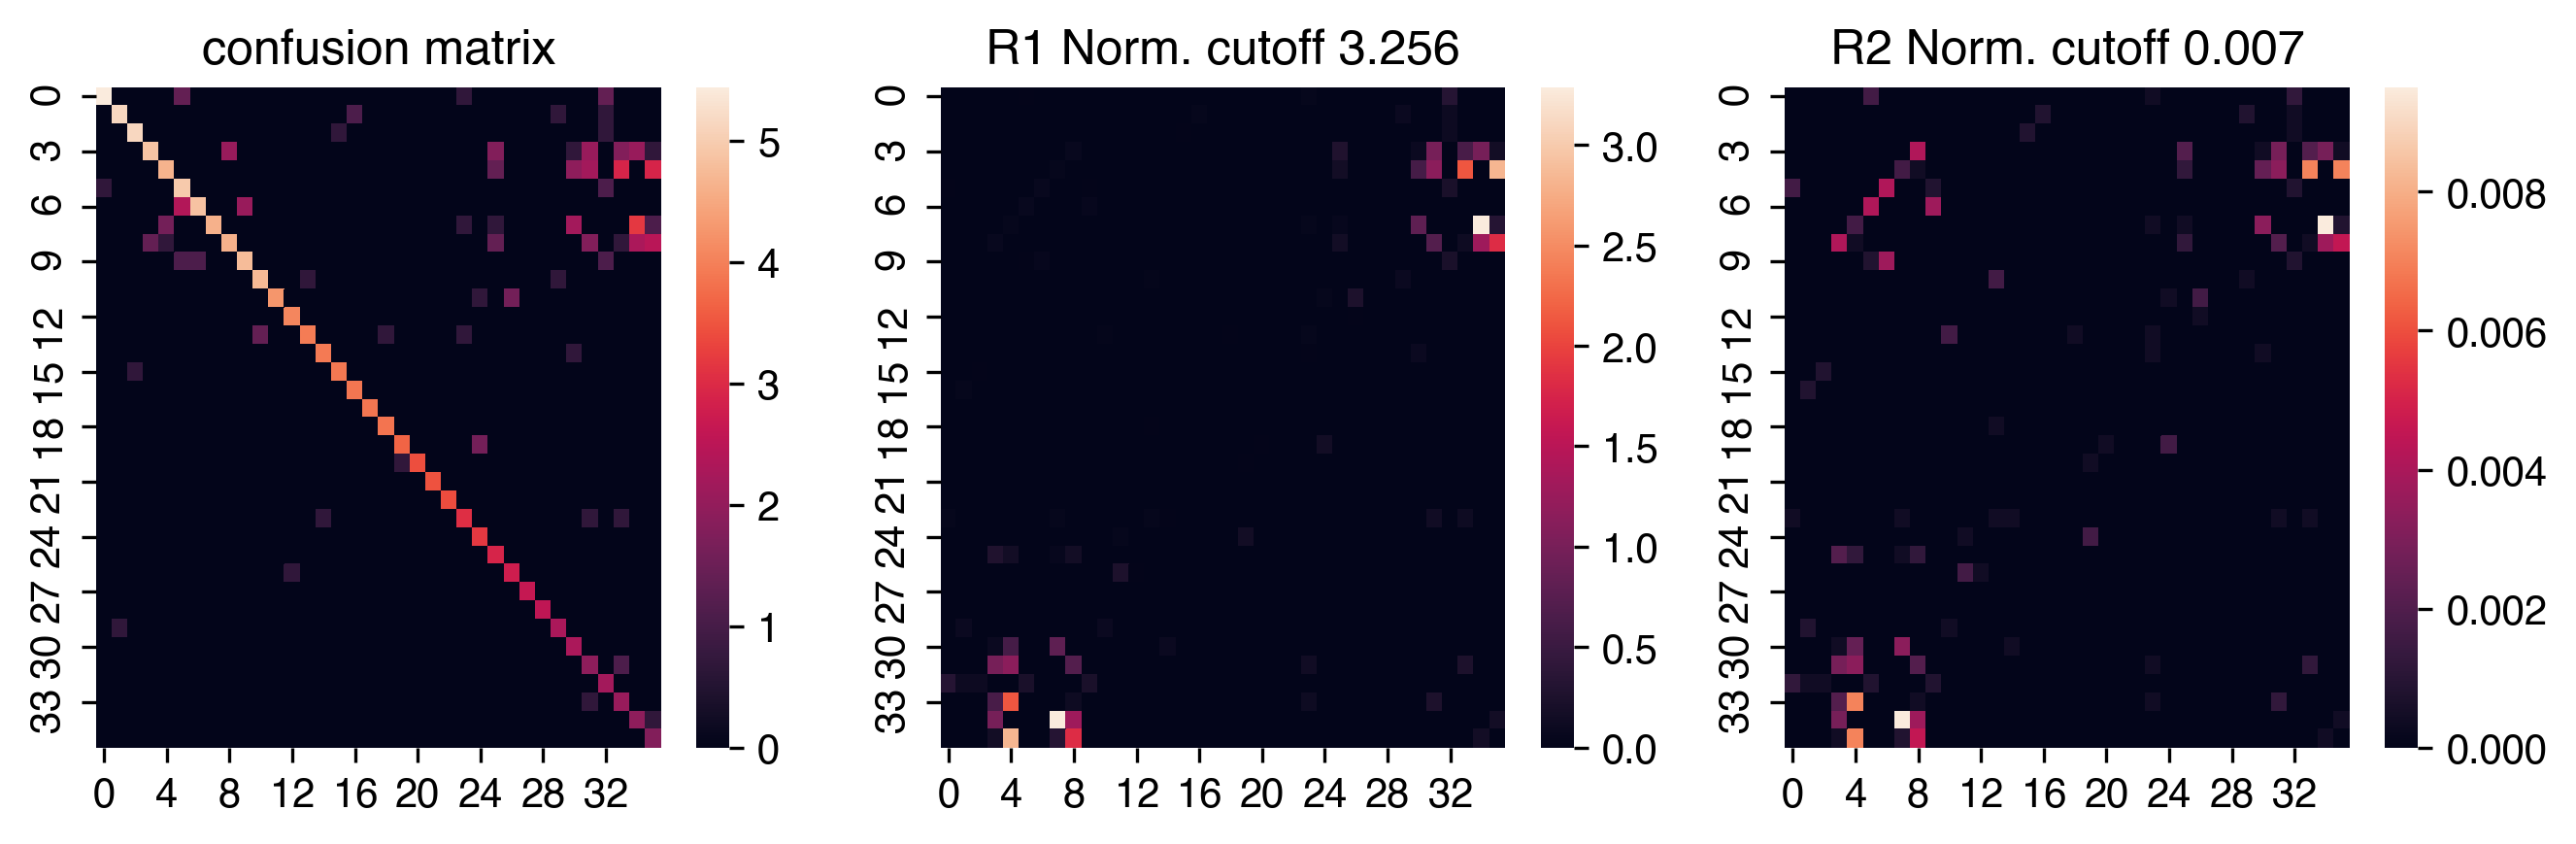

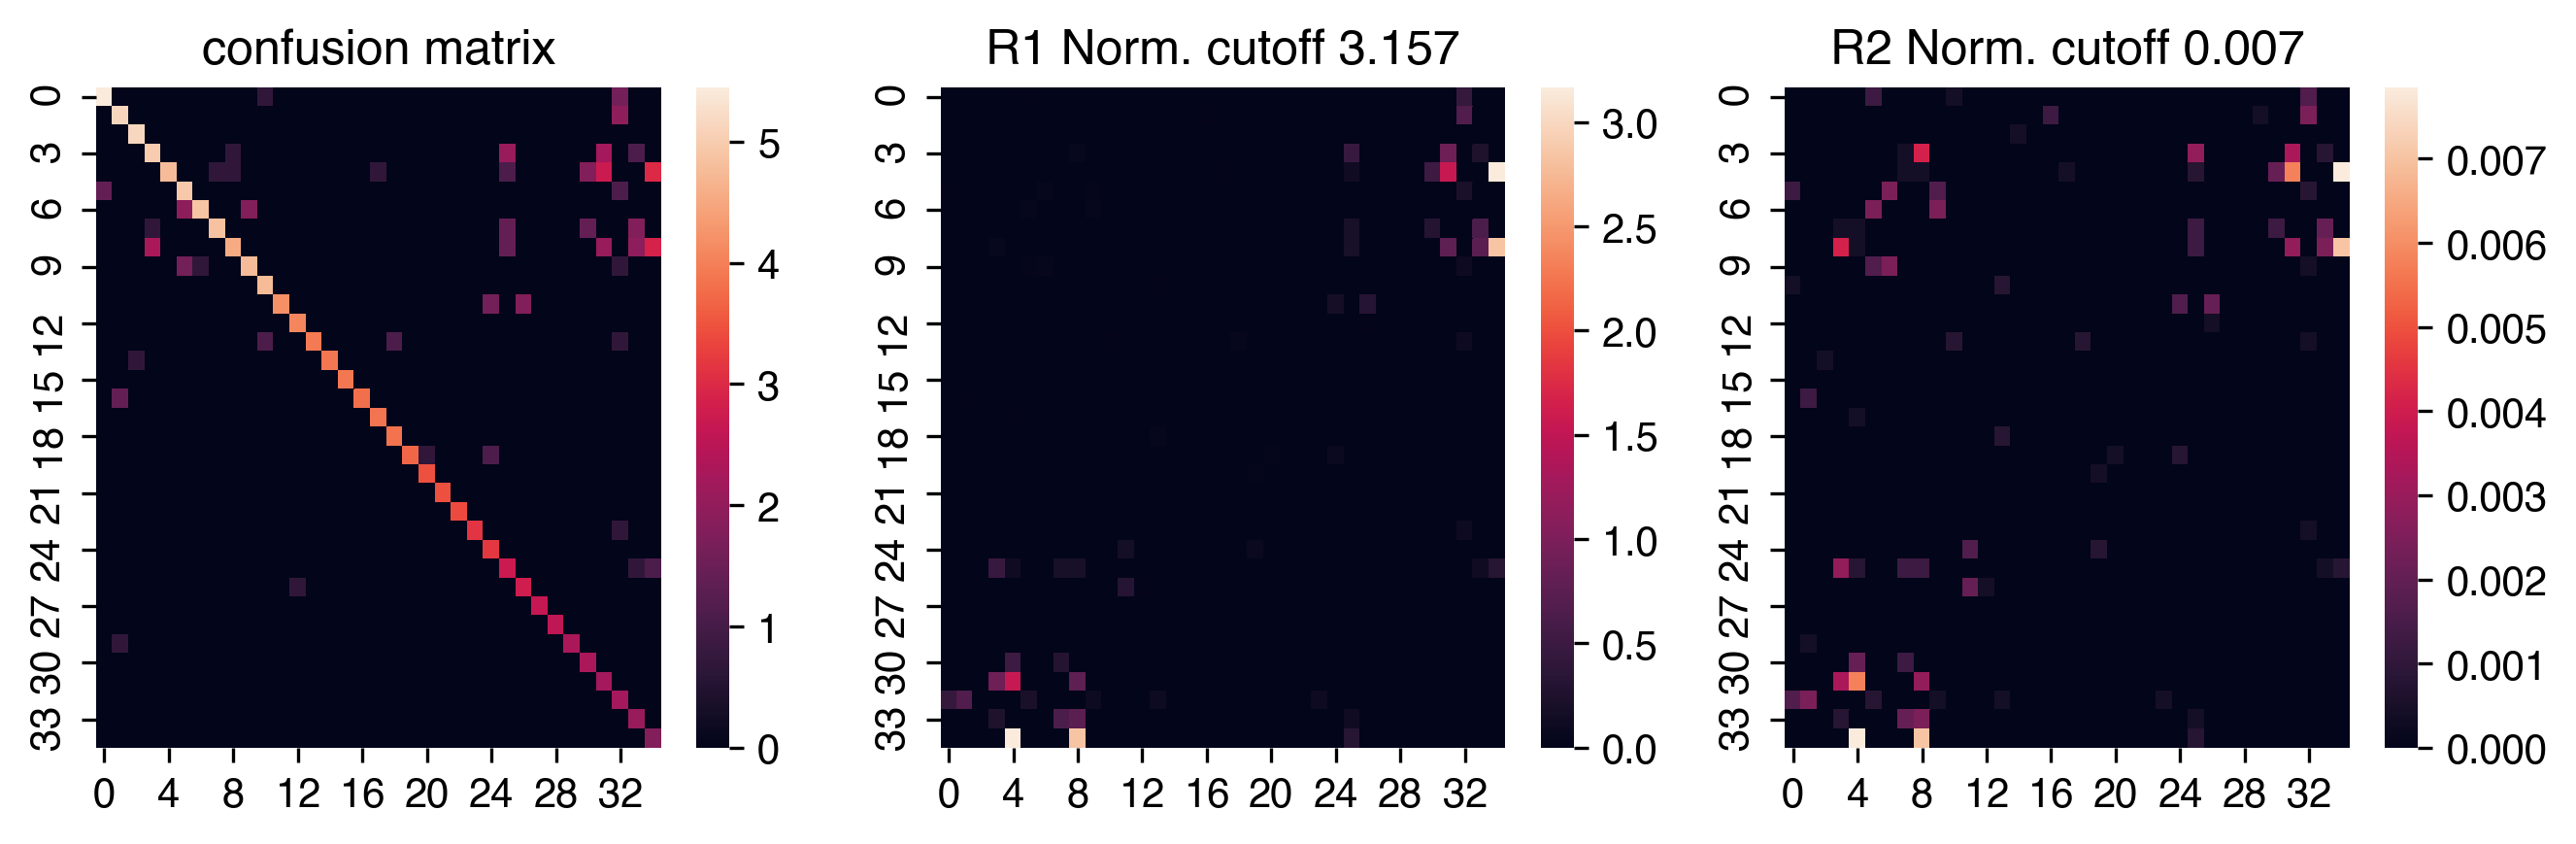

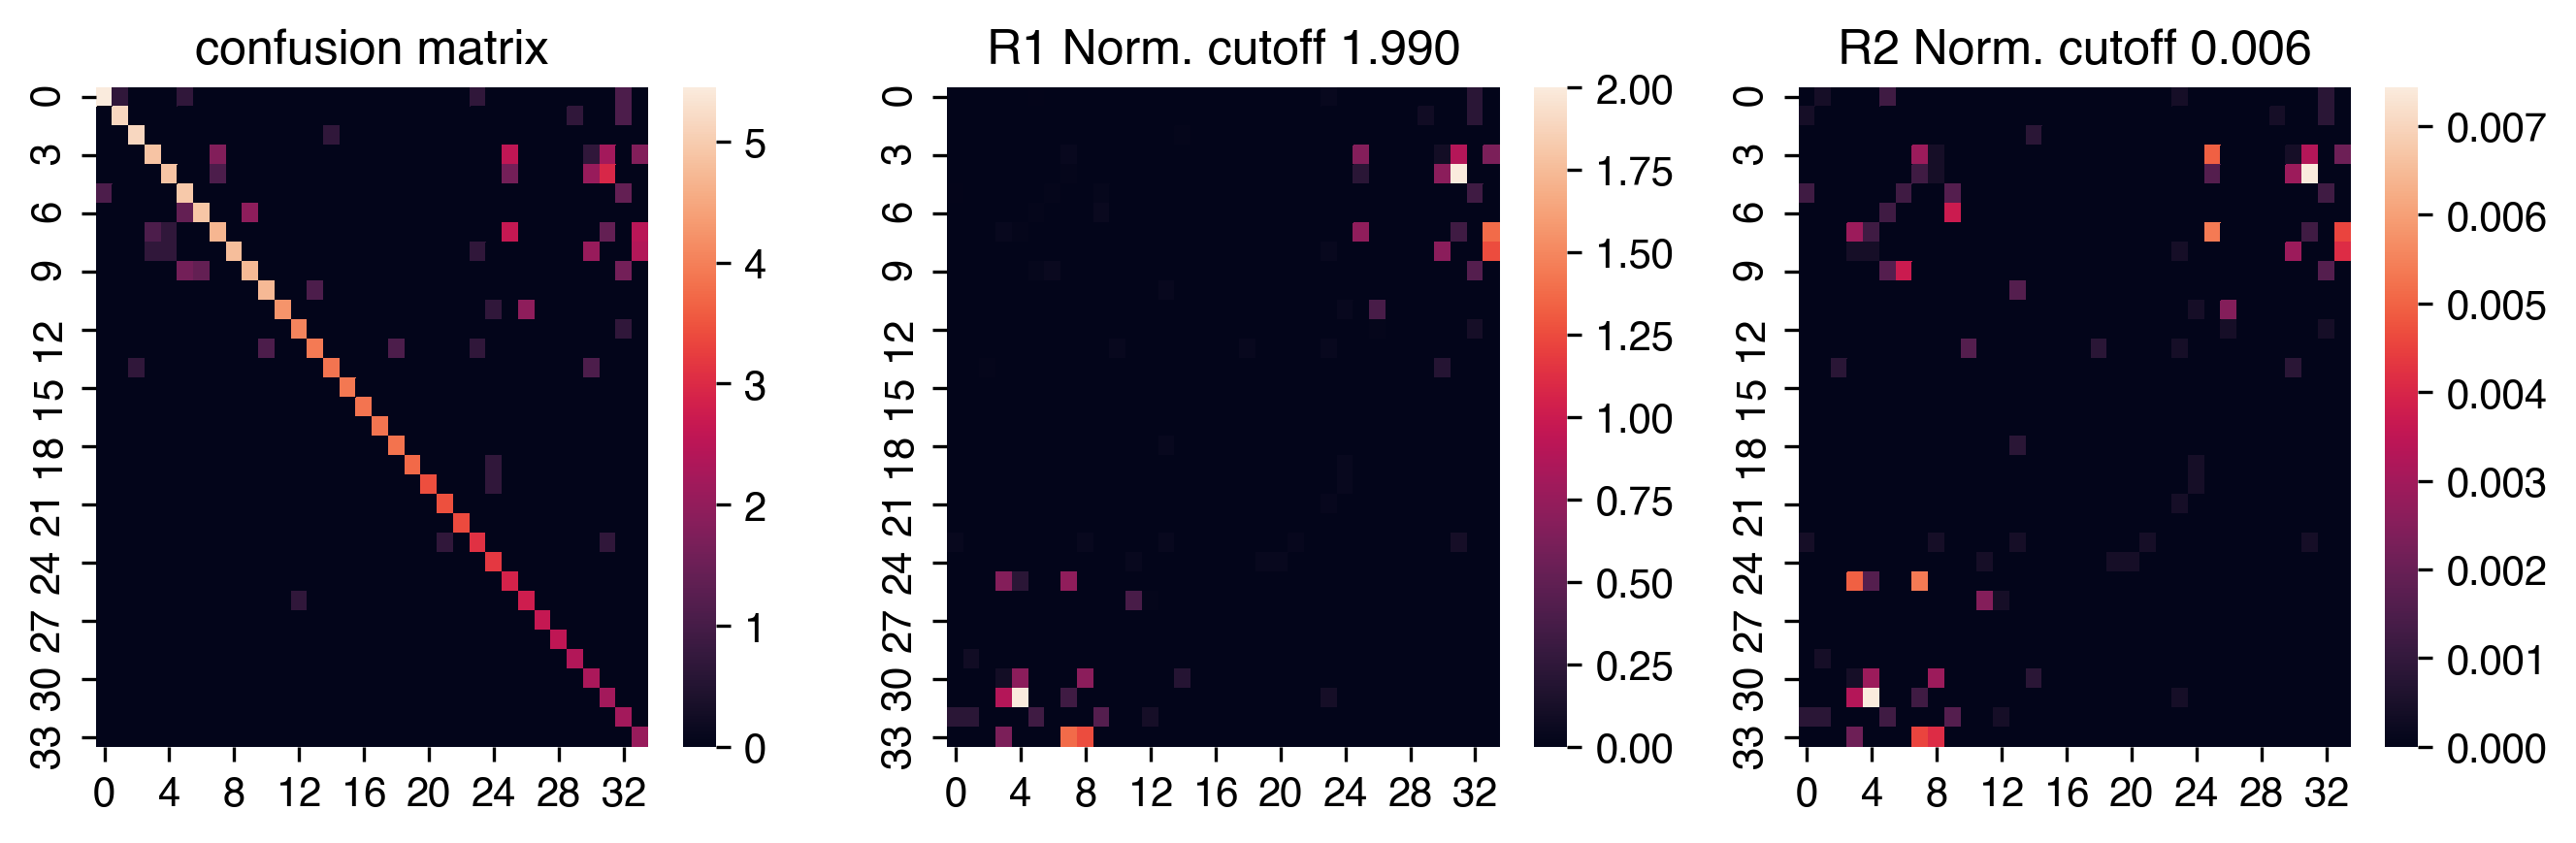

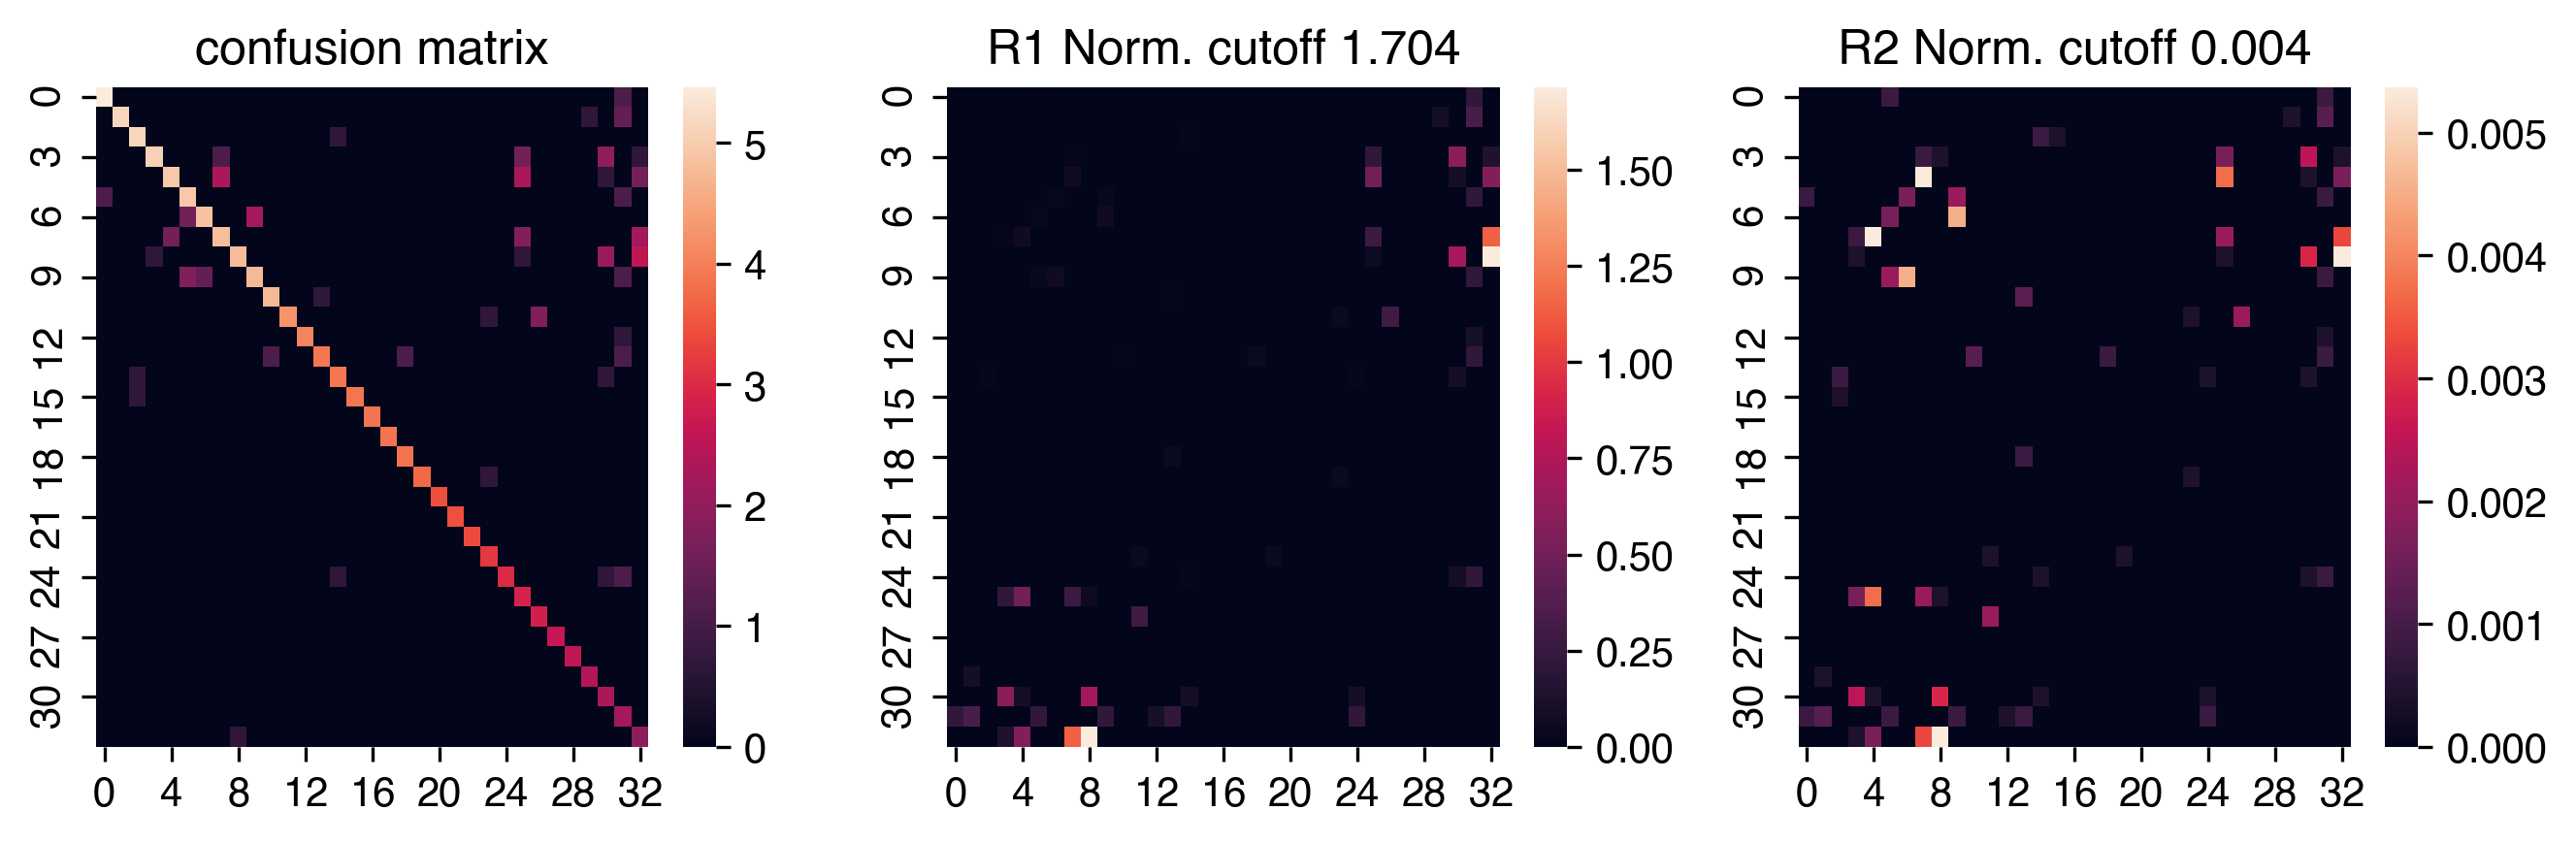

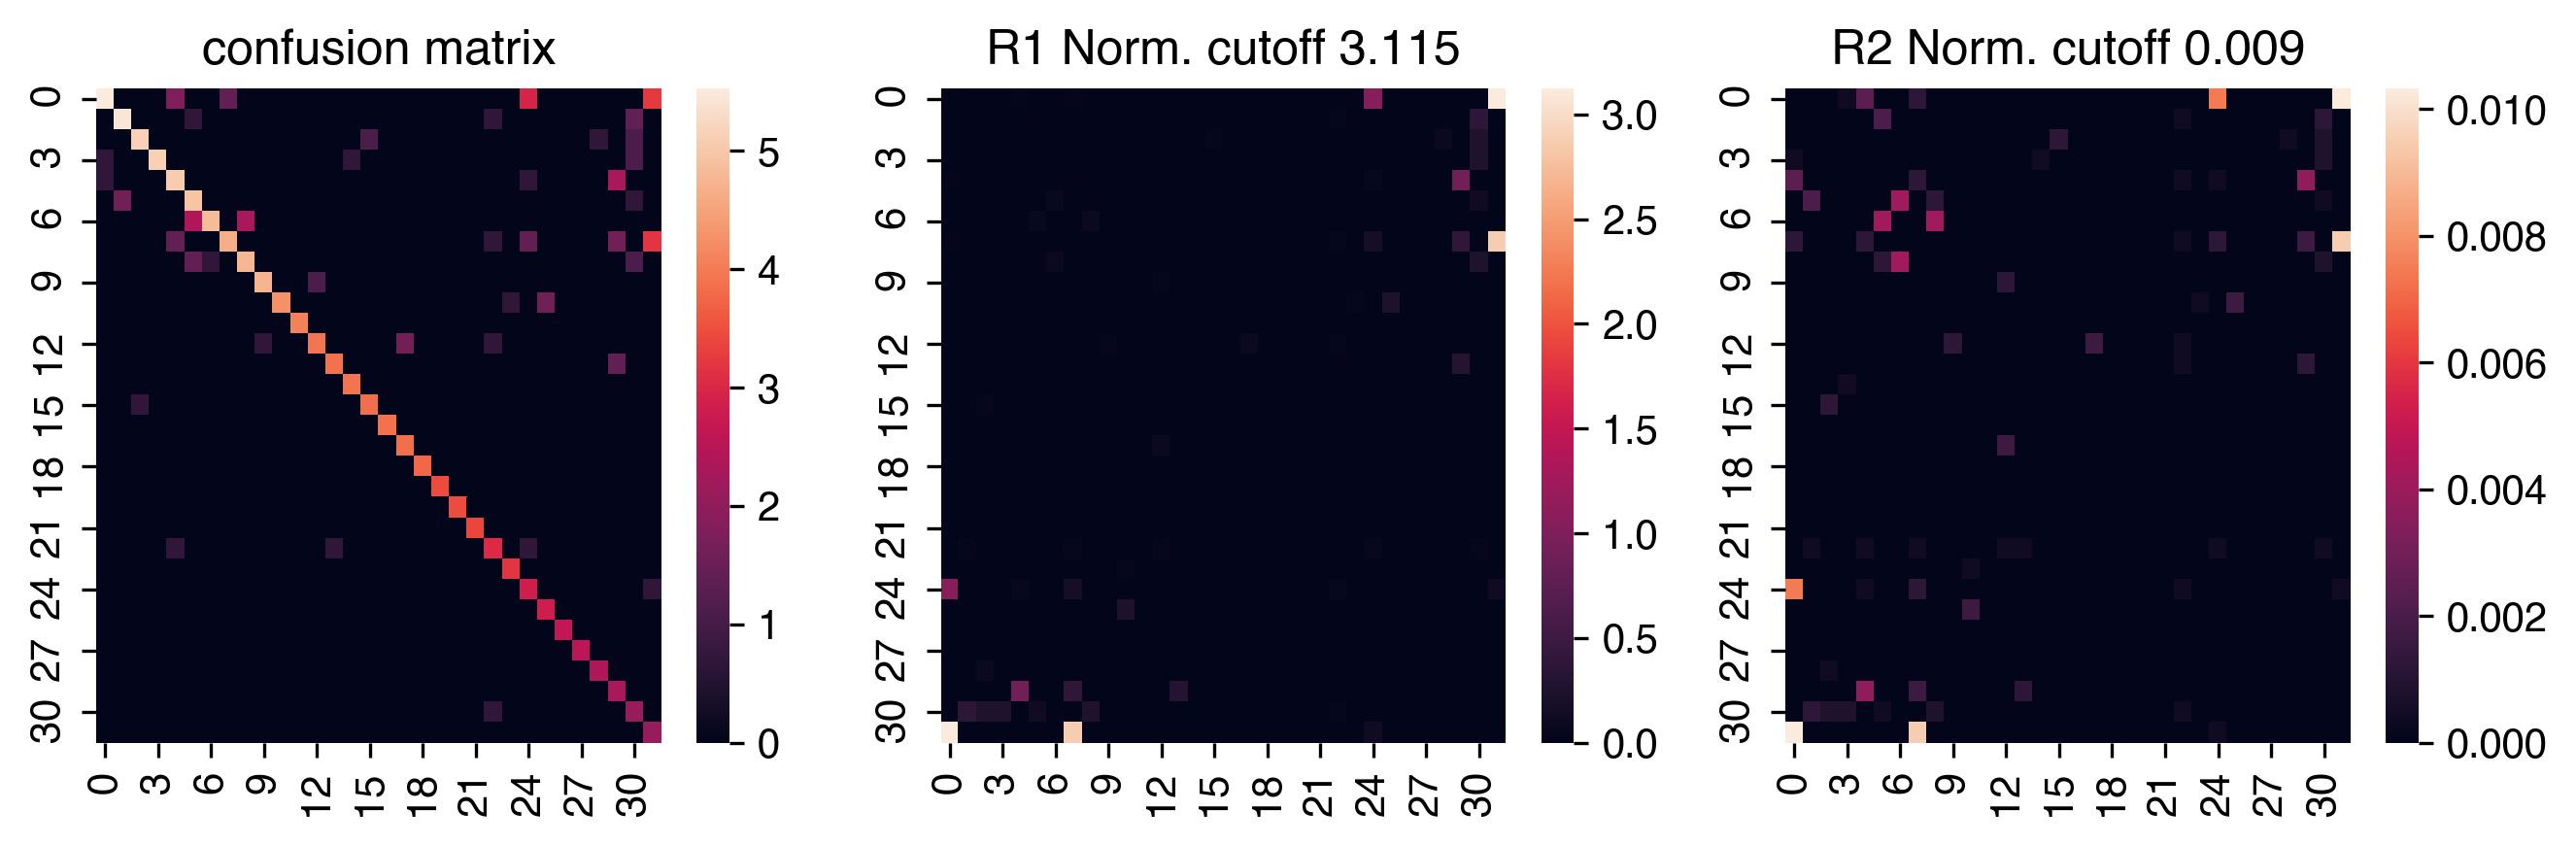

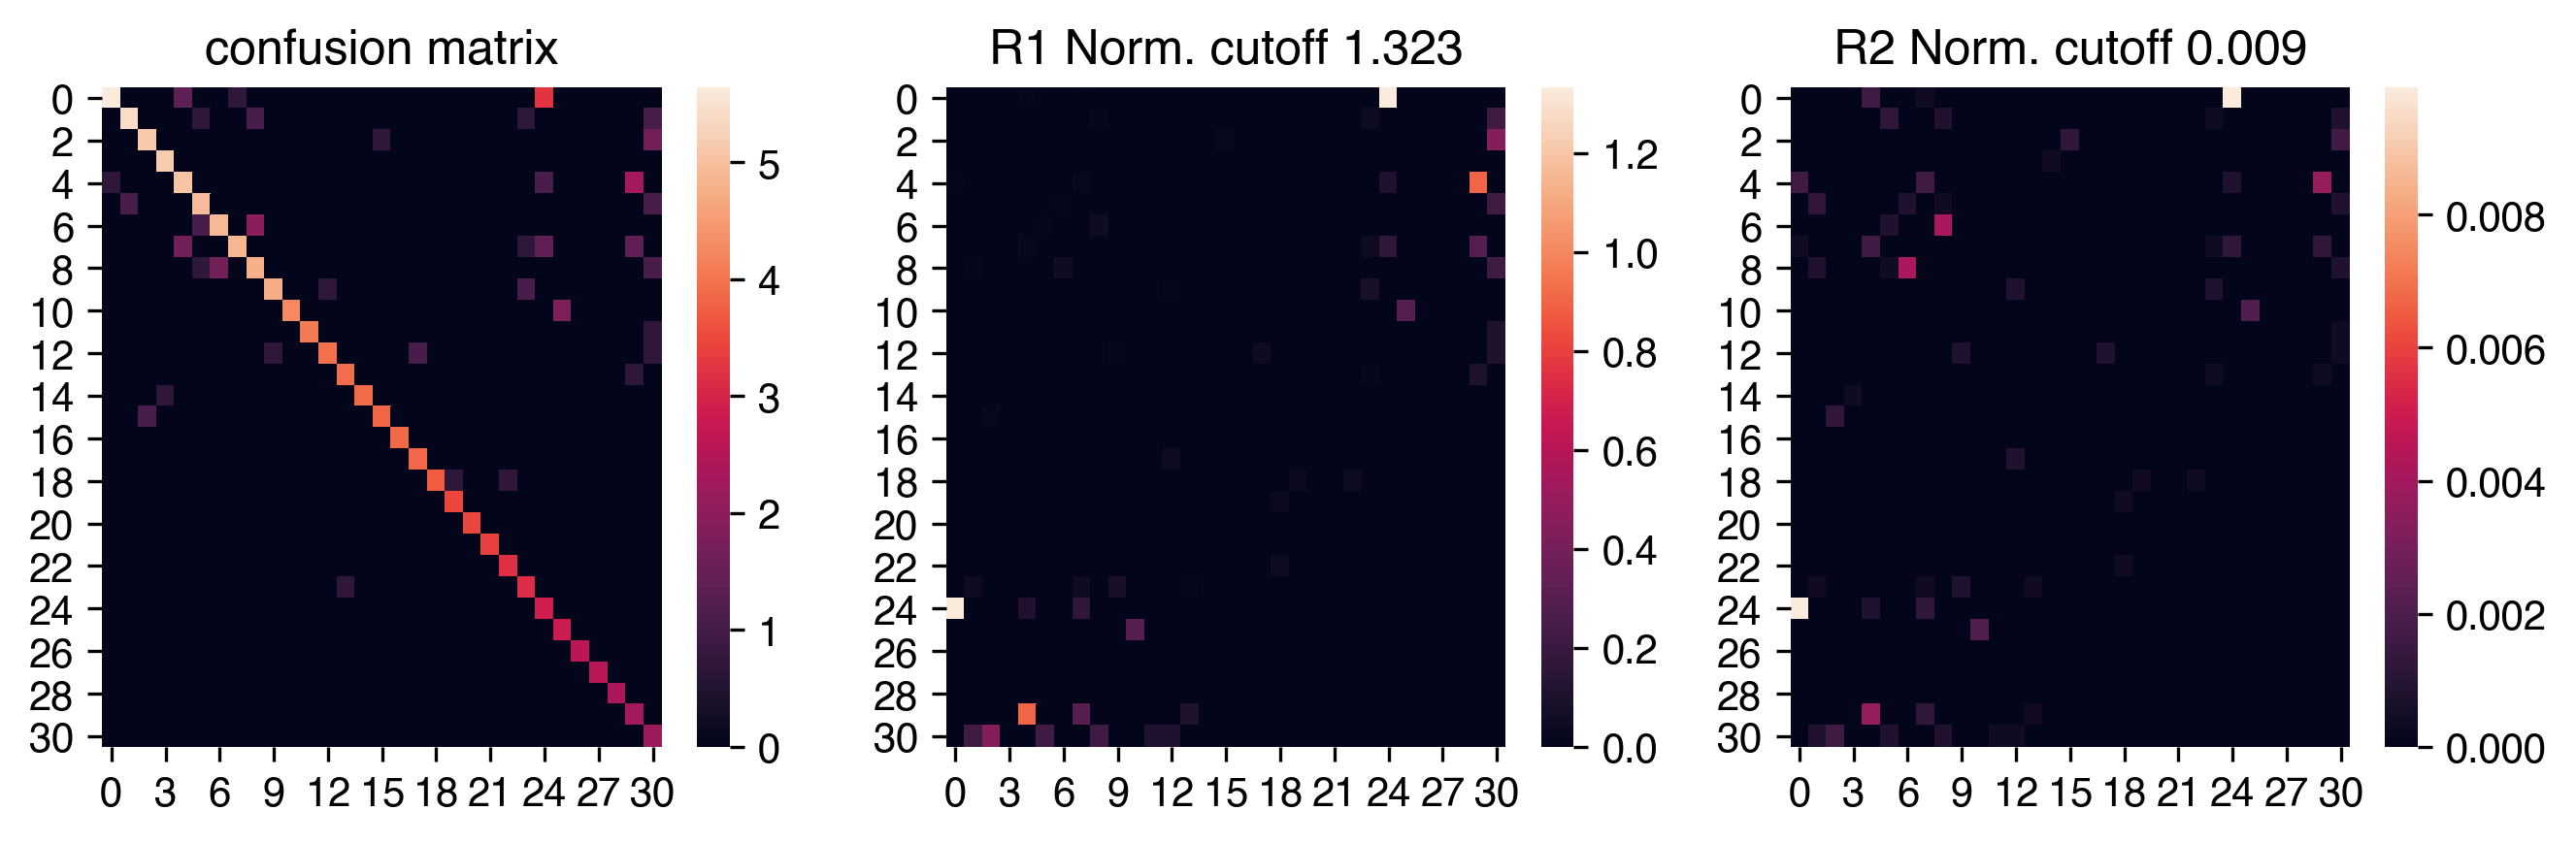

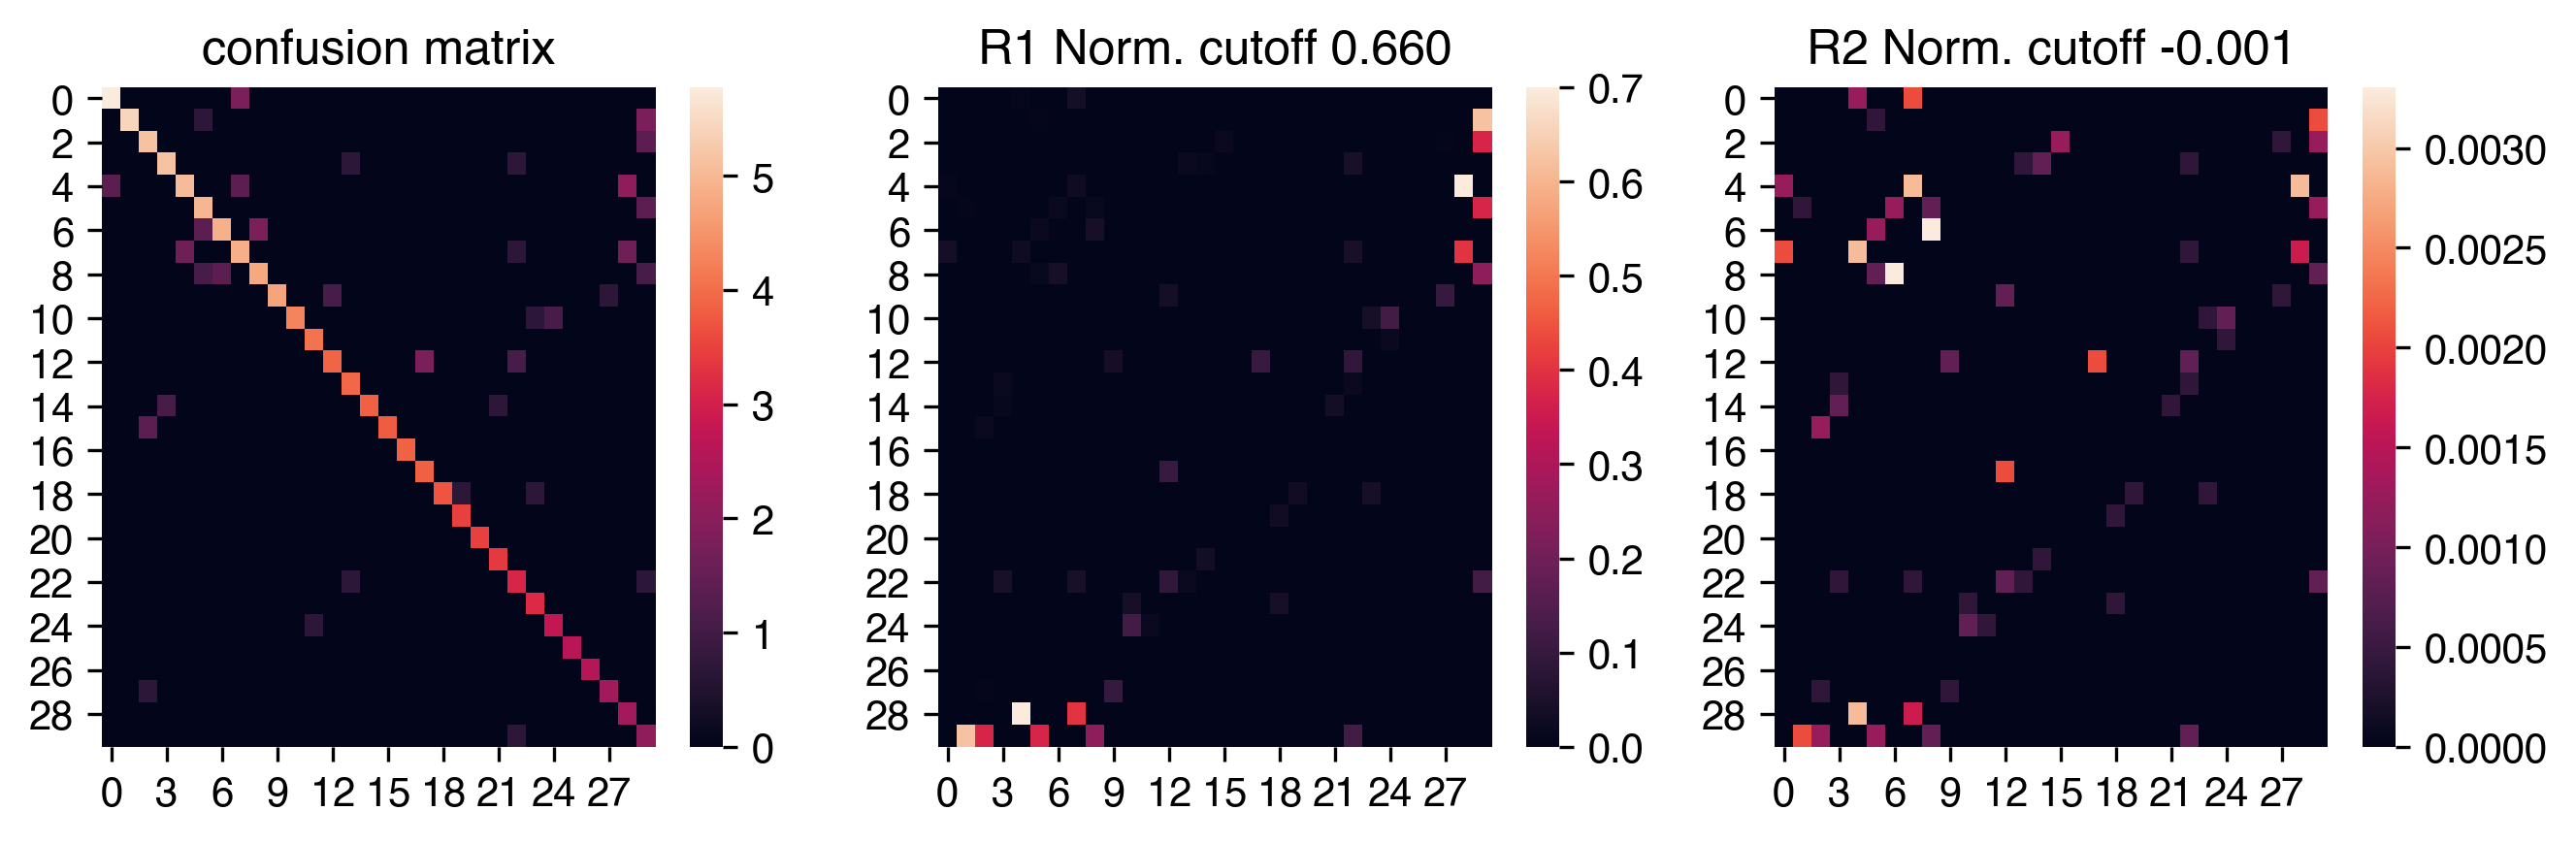

In [5]:
if 'X_pca' not in adata.obsm:
    raise KeyError(
        'X_pca do not exist in the adata file, run PCA first before clustering.'
    )
cc.fit_predict(adata.obsm['X_pca'])

## Plot

### Cluster Lables

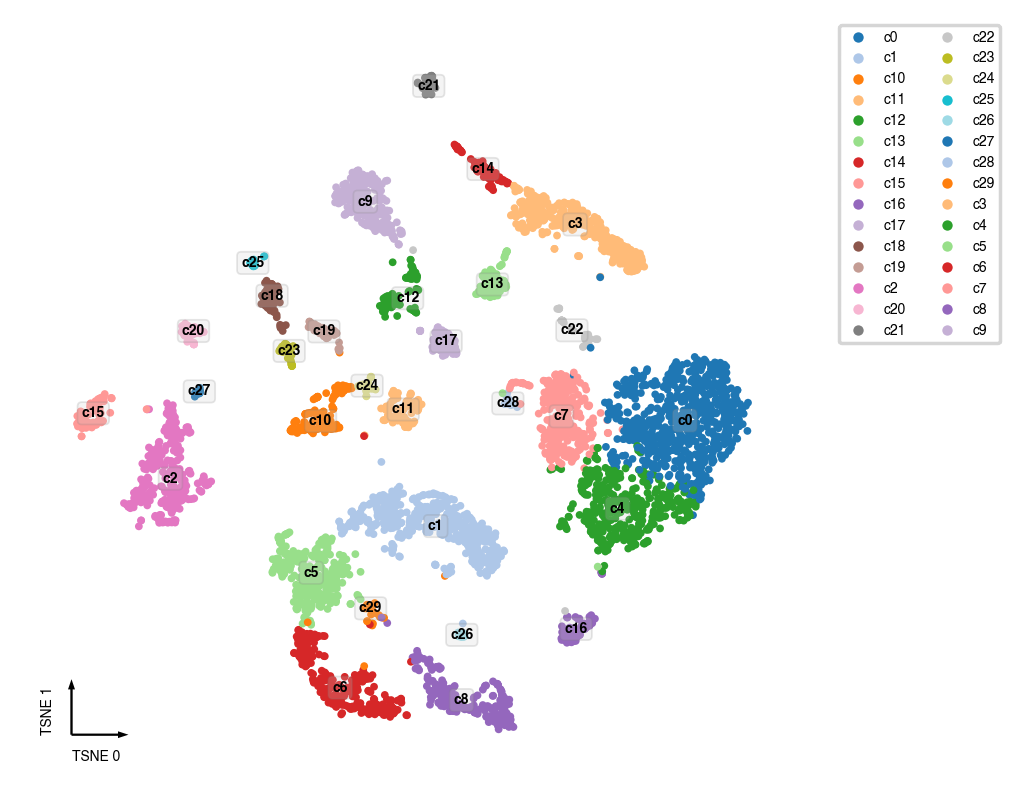

In [32]:
adata.obs[clustering_name] = cc.label

fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
_ = categorical_scatter(data=adata.obs,
                        ax=ax,
                        hue=clustering_name,
                        coord_base=coord_base,
                        palette='tab20',
                        text_anno=clustering_name,
                        show_legend=True)

### Final Prediction Probability

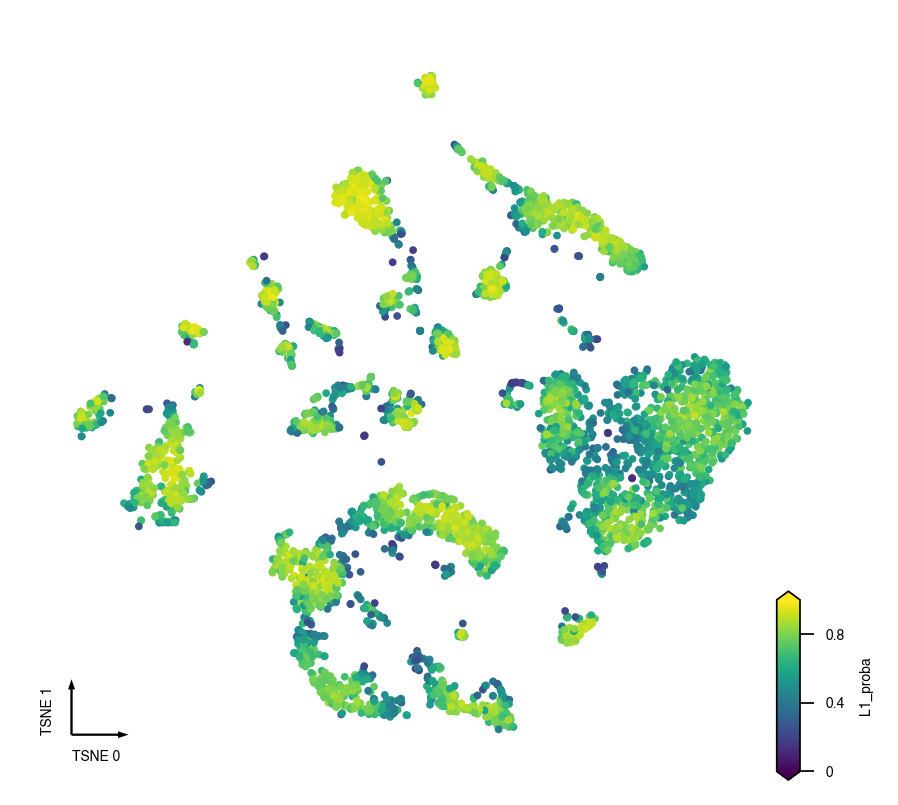

In [34]:
adata.obs[clustering_name + '_proba'] = cc.label_proba

fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
_ = continuous_scatter(data=adata.obs,
                       ax=ax,
                       hue_norm=(0, 1),
                       hue=clustering_name + '_proba',
                       coord_base=coord_base)

### Prediction Probability Per Cluster

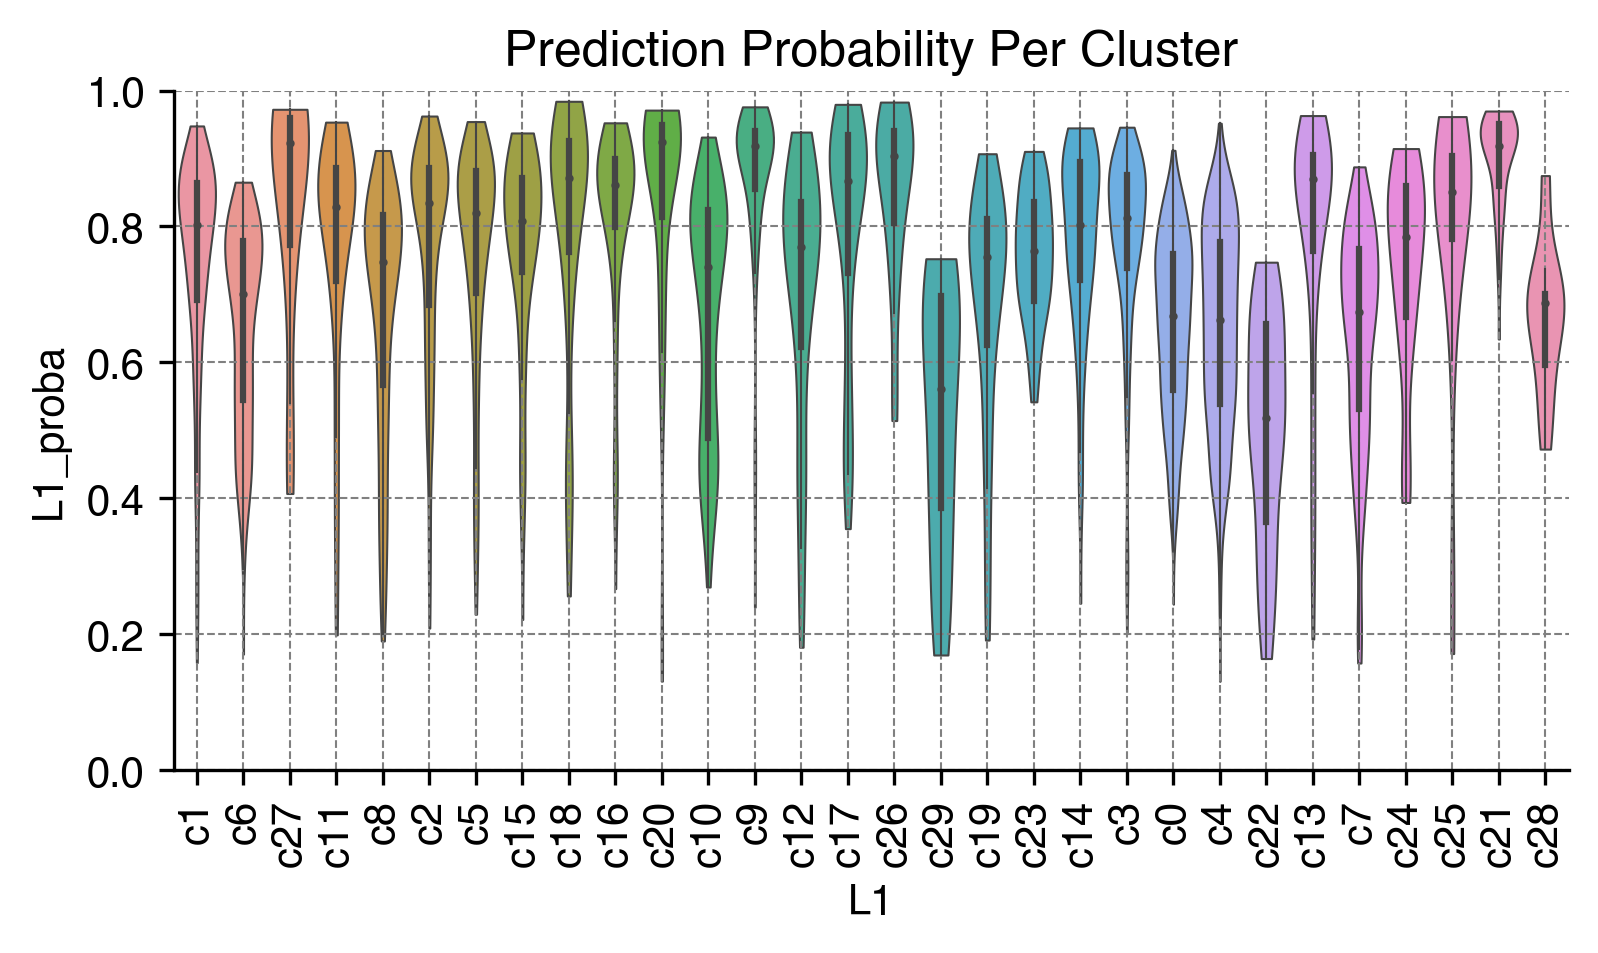

In [35]:
fig, ax = plt.subplots(figsize=(6, 3), dpi=300)

sns.violinplot(data=adata.obs,
               x=clustering_name,
               y=clustering_name + '_proba',
               scale='width',
               linewidth=0.5,
               cut=0,
               ax=ax)
ax.set(ylim=(0, 1), title='Prediction Probability Per Cluster')
ax.xaxis.set_tick_params(rotation=90)
ax.grid(linewidth=0.5, color='gray', linestyle='--')
sns.despine(ax=ax)

## Calculate Cluster Dendrogram

In [20]:
# using the cluster centroids in PC space to calculate dendrogram
pc_matrix = adata.obsm['X_pca']
pc_center = pd.DataFrame(pc_matrix, index=adata.obs_names).groupby(
    adata.obs[clustering_name]).median()
pc_center = pc_center[pc_center.index != outlier_label]
# Dendrogram take feature-by-sample dataframe as R pvclust function does.
pc_center = pc_center.T
idx_to_cluster = {i: c for i, c in enumerate(pc_center.index)}

pc_center.to_hdf('ClusterPCCenters.hdf', key='data')
pc_center.shape

(67, 30)

Creating a temporary cluster...done:
socket cluster with 40 nodes on host ‘localhost’
Multiscale bootstrap... Done.


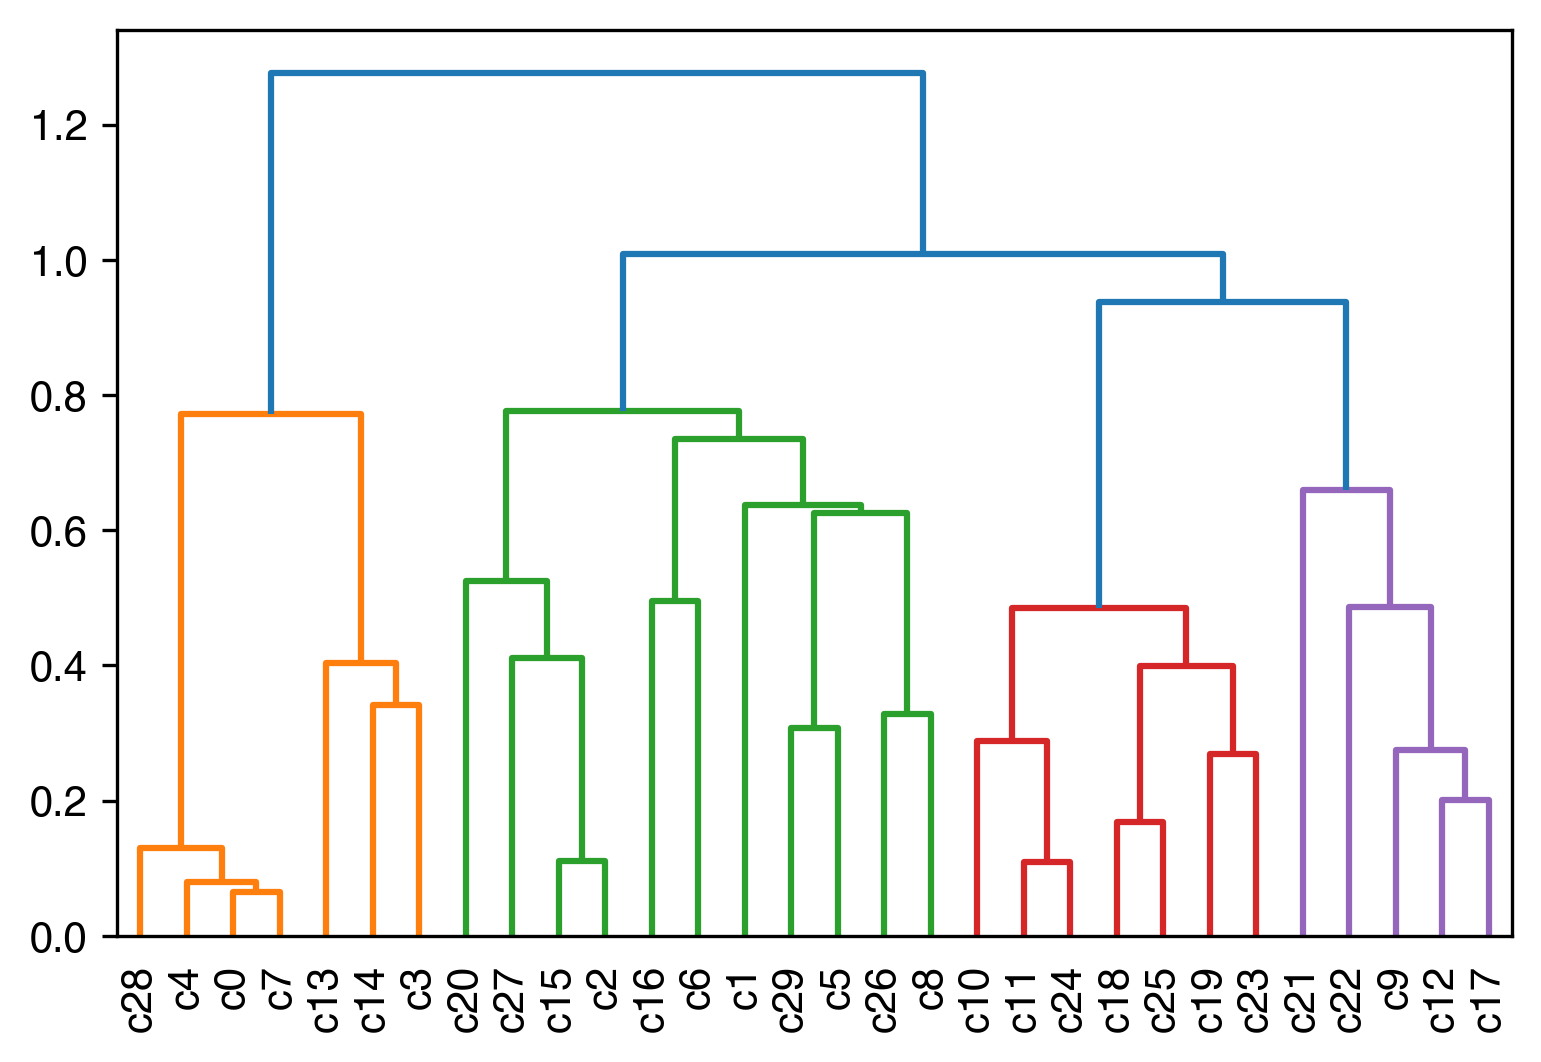

In [21]:
dendro = Dendrogram(nboot=nboot,
                    method_dist=method_dist,
                    method_hclust=method_hclust,
                    n_jobs=n_jobs)
dendro.fit(pc_center, plot=True)

## Sanity Test

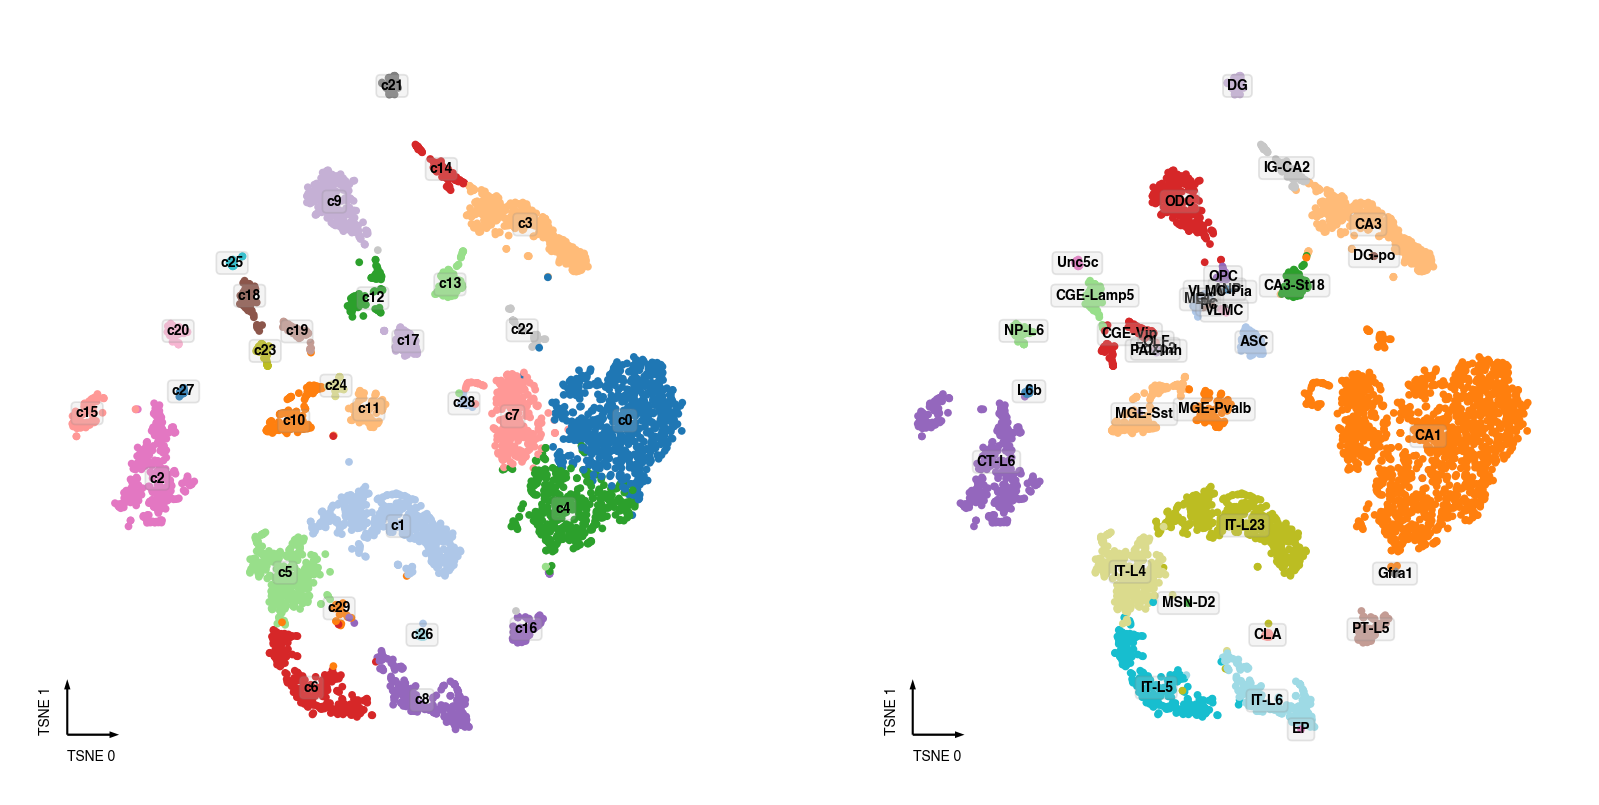

In [48]:
if 'CellTypeAnno' in cell_meta:
    fig, axes = plt.subplots(figsize=(8, 4), dpi=250, ncols=2)
    ax = axes[0]
    _ = categorical_scatter(data=adata.obs,
                            ax=ax,
                            hue=clustering_name,
                            coord_base=coord_base,
                            palette='tab20',
                            text_anno=clustering_name,
                            show_legend=False)
    ax = axes[1]
    adata.obs['CellTypeAnno'] = cell_meta['CellTypeAnno']
    _ = categorical_scatter(data=adata.obs.dropna(subset=['CellTypeAnno']),
                            ax=ax,
                            hue='CellTypeAnno',
                            coord_base=coord_base,
                            palette='tab20',
                            text_anno='CellTypeAnno',
                            show_legend=False)

## Save

In [22]:
cc.save('ConcensusClustering.model.lib')
dendro.save('Dendrogram.lib')
adata.write_h5ad(adata_path)

... storing 'L1' as categorical
... storing 'CellTypeAnno' as categorical


In [23]:
adata

AnnData object with n_obs × n_vars = 4958 × 2868
    obs: 'leiden', 'mCHFrac', 'tsne_0', 'tsne_1', 'umap_0', 'umap_1', 'L1', 'L1_proba', 'CellTypeAnno'
    var: 'chrom', 'bin_start', 'bin_end', 'CHN_mean', 'CHN_dispersion', 'CHN_cov', 'CHN_score', 'CHN_feature_select', 'CGN_mean', 'CGN_dispersion', 'CGN_cov', 'CGN_score', 'CGN_feature_select', 'leiden_enriched_features', 'mean', 'std'
    uns: 'leiden', 'leiden_colors', 'leiden_feature_enrichment', 'leiden_sizes', 'neighbors', 'paga', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'